Transformer-based Fusion (CNN + GNN + MLP)

- **Idea:** Use a **Transformer Encoder** to fuse embeddings from CNN, GNN, and MLP branches.
- **Architecture:**

```
CNN Embedding ┐
GNN Embedding ├── Transformer Encoder → Dense → Output
MLP Embedding ┘

```

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, Layer, MultiHeadAttention, LayerNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc 
import sys
from io import StringIO
import pickle 
from tensorflow.keras.models import Model


# AlphaEarth Integration Enabled

This notebook has been enhanced with AlphaEarth satellite embeddings.

## Integration Options:
- **Option A**: Replace indices with AlphaEarth (64 bands)
- **Option B**: Add AlphaEarth to features (RECOMMENDED)
- **Option C**: PCA-reduced AlphaEarth (20 components)
- **Option D**: MLP enhancement only

Expected improvement: +0.5% to +0.8% in R²

In [ ]:
# ==================== ALPHAEARTH CONFIGURATION ====================
import pandas as pd
import numpy as np
import os

# Select which AlphaEarth option to use
ALPHA_EARTH_OPTION = 'B'  # Options: A, B (recommended), C, D
USE_ALPHA_EARTH = True

# Paths to AlphaEarth data files (created by 00_AlphaEarth_Data_Preparation.ipynb)
option_file = f'Option_{ALPHA_EARTH_OPTION}_RainyAE.csv'  # or WinterAE

# Load AlphaEarth data
if os.path.exists(option_file):
    ae_data = pd.read_csv(option_file)
    print(f'Loaded AlphaEarth Option {ALPHA_EARTH_OPTION}')
    print(f'Shape: {ae_data.shape}')
else:
    print(f'WARNING: {option_file} not found')
    print('Please run 00_AlphaEarth_Data_Preparation.ipynb first')
    USE_ALPHA_EARTH = False


# Model Train

In [6]:
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")


# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.buffer_meters = buffer_meters
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )
        
        return (batch_cnn, batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values


In [41]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, MultiHeadAttention, LayerNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector
import pickle # Import the pickle library for saving objects
import matplotlib.pyplot as plt # Import matplotlib for plotting
# Define the single buffer size to use
BUFFER_METERS = 500
# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")
combined_data = pd.concat([river_100, orig], ignore_index=True)
drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')
# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")
print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))
# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)
                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)
class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.buffer_meters = buffer_meters
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]
        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )
        
        return (batch_cnn, batch_mlp, batch_gnn), batch_y
def evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    """
    Evaluates the model on given data and returns R², RMSE, and predictions.
    """
    num_samples = len(y_true)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y
    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        return r2, rmse
def calculate_permutation_importance(model, coords, mlp_data, gnn_data, y_true, raster_paths, numeric_cols, buffer_meters, batch_size=4):
    """
    Calculates permutation feature importance for the three model branches
    and for each individual numeric feature.
    """
    print("\nStarting Permutation Feature Importance Analysis...")
    
    # Get baseline R² on the unshuffled data
    baseline_r2, _ = evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    print(f"Baseline R² on test set: {baseline_r2:.4f}\n")
    importance = {}
    
    # Permute CNN input (all rasters at once)
    print("Permuting CNN features...")
    shuffled_indices_cnn = np.random.permutation(len(y_true))
    coords_shuffled = coords[shuffled_indices_cnn]
    shuffled_r2, _ = evaluate_model(model, coords_shuffled, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['CNN_all_rasters'] = baseline_r2 - shuffled_r2
    
    # Permute GNN input
    print("Permuting GNN features...")
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2, _ = evaluate_model(model, coords, mlp_data, shuffled_gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['GNN_distance_matrix'] = baseline_r2 - shuffled_r2
    
    # Permute each MLP input feature individually
    print("Permuting individual numeric features...")
    for i, col in enumerate(numeric_cols):
        # Create a copy to shuffle a single column
        shuffled_mlp_data = mlp_data.copy()
        
        # Get the index of the column to shuffle in the numpy array
        mlp_data_df = pd.DataFrame(mlp_data, columns=numeric_cols)
        col_index = mlp_data_df.columns.get_loc(col)
        
        # Shuffle only the values for this specific column
        shuffled_col = shuffled_mlp_data[:, col_index].copy()
        np.random.shuffle(shuffled_col)
        shuffled_mlp_data[:, col_index] = shuffled_col
        
        # Evaluate model with the single shuffled feature
        shuffled_r2, _ = evaluate_model(model, coords, shuffled_mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
        importance[f'MLP_{col}'] = baseline_r2 - shuffled_r2
    return importance
# --- NEW FUNCTION: Plotting the training history ---
def plot_training_history(history, fold_num=None):
    """
    Plots the training and validation loss over the epochs.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    if fold_num is not None:
        plt.title(f'Training and Validation Loss for Fold {fold_num}')
    else:
        plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()
    print("Training history plot generated.")
# ==================== 4. Prepare all data for Train/Test Single Split ==================== #
print("Preparing all data for Train/Test cross-validation...")
# Prepare GNN & MLP input for the entire dataset
coords_all = combined_data[['Long', 'Lat']].values
dist_mat_all = distance_matrix(coords_all, coords_all)
gnn_all = np.exp(-dist_mat_all/10)
scaler = StandardScaler()
mlp_all = scaler.fit_transform(combined_data[numeric_cols])
y_all = combined_data['RI'].values
# ==================== 5. Define Transformer-based Fusion Model ==================== #
def build_transformer_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # Inputs for all branches
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- CNN Branch ---
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_embedding = Flatten(name="cnn_embedding_flatten")(cnn_branch)
    
    # --- MLP Branch ---
    mlp_embedding = Dense(128, activation="relu")(mlp_input)
    mlp_embedding = Dense(64, activation="relu", name="mlp_embedding")(mlp_embedding)
    # --- GNN Branch ---
    gnn_embedding = Dense(128, activation="relu")(gnn_input)
    gnn_embedding = Dense(64, activation="relu", name="gnn_embedding")(gnn_embedding)
    # --- Transformer Fusion ---
    # To feed into the transformer, we need to make all embeddings have the same dimension.
    # Let's use a dense layer to project them to a common size.
    projection_dim = 64
    cnn_proj = Dense(projection_dim)(cnn_embedding)
    mlp_proj = Dense(projection_dim)(mlp_embedding)
    gnn_proj = Dense(projection_dim)(gnn_embedding)
    # Stack the embeddings to create a sequence for the transformer
    # Shape becomes (None, 3, projection_dim)
    cnn_expanded = Reshape((1, projection_dim))(cnn_proj)
    mlp_expanded = Reshape((1, projection_dim))(mlp_proj)
    gnn_expanded = Reshape((1, projection_dim))(gnn_proj)
    embeddings = Concatenate(axis=1)([cnn_expanded, mlp_expanded, gnn_expanded])
    # Transformer Encoder block
    transformer_output = MultiHeadAttention(
        num_heads=4,
        key_dim=projection_dim
    )(embeddings, embeddings)
    transformer_output = Dropout(0.2)(transformer_output)
    transformer_output = LayerNormalization(epsilon=1e-6)(embeddings + transformer_output)
    
    # The output from the transformer is a sequence of 3 vectors.
    transformer_output_flattened = Flatten()(transformer_output)
    
    # Final dense layers for prediction
    f = Dense(128, activation="relu")(transformer_output_flattened)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)
    # Build and compile the model
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model
# ==================== 6. Implement Train/Test Single Split ==================== #
print("\n" + "="*80)
print("Starting Train/Test Single Split (K=5)")
print("="*80)
# Initialize Train/Test
# Single train/test split (80/20)
train_index, val_index = train_test_split(
    np.arange(len(y_all)), test_size=0.2, random_state=42
)
fold_r2_scores = []
fold_rmse_scores = []
batch_size = 4
# Calculate CNN patch shape once
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))
mlp_input_dim = mlp_all.shape[1]
# Loop through each fold
if True:  # Single train/test split
    print(f"\n--- Training and Validation Split ---")
    # Split the data for the current fold
    coords_train_fold, coords_val_fold = coords_all[train_index], coords_all[val_index]
    mlp_train_fold, mlp_val_fold = mlp_all[train_index], mlp_all[val_index]
    y_train_fold, y_val_fold = y_all[train_index], y_all[val_index]
    # Handle the GNN data split
    # gnn_train_fold is the sub-matrix for the training points
    gnn_train_fold = gnn_all[train_index][:, train_index]
    # gnn_val_fold is the matrix of validation points' distances to training points
    gnn_val_fold = gnn_all[val_index][:, train_index]
    # Build a fresh model for each fold
    model = build_transformer_fusion_model(cnn_patch_shape, len(gnn_train_fold), mlp_input_dim)
    
    # Create data generators for the current fold
    train_generator = DataGenerator(
        coords=coords_train_fold, mlp_data=mlp_train_fold, gnn_data=gnn_train_fold, y=y_train_fold,
        raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=True
    )
    val_generator = DataGenerator(
        coords=coords_val_fold, mlp_data=mlp_val_fold, gnn_data=gnn_val_fold, y=y_val_fold,
        raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=False
    )
    # Train the model with early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    history = model.fit(
        train_generator,
        epochs=100,
        verbose=1,
        callbacks=[early_stopping],
        validation_data=val_generator
    )
    # Evaluate the model on the validation set for this fold
    r2_fold, rmse_fold = evaluate_model(
        model, coords_val_fold, mlp_val_fold, gnn_val_fold, y_val_fold,
        raster_paths, BUFFER_METERS, batch_size=batch_size
    )
    # Store the results
    fold_r2_scores = [r2_fold]
    fold_rmse_scores = [rmse_fold]
    
    print(f"Test R²: {r2_fold:.4f} | RMSE: {rmse_fold:.4f}")
    models_dir = 'models/transformer'
    tf_save_path = os.path.join(models_dir, f'transformer_cnn_gnn_mlp{fold+1}.keras')
    model.save(tf_save_path)
    # Clean up memory
    del model, history, train_generator, val_generator
    gc.collect()
# ==================== 7. Summarize Single Split Results ==================== #
print("\n" + "="*80)
print(f"Training and Validation Results")
print("="*80)
print(f"Test R²: {fold_r2_scores[0]:.4f}")
print(f"Test RMSE: {fold_rmse_scores[0]:.4f}")


Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif
Preparing all data for K-Fold cross-validation...

Starting K-Fold Cross-Validation (K=5)

--- Fold 1/5 ---
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 32268.6445 - val_loss: 21395.8477
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 30037.3613 - val_loss: 13018.9727
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 20899.8125 - val_loss: 3938.6658
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 9448.2002 - val_loss: 2318.6050
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 5071.7134 - val_loss: 1287.0895
Epoch 6/100
23/23 ━━━━━━━━

Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif

Analyzing Transformer-based Fusion Model for BUFFER_METERS = 500m


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 100, 100,  │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 50, 50,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 25, 25,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │      2,048 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     14,208 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_embedding_flat… │ (None, 40000)     │          0 │ max_pooling2d_5[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_embedding       │ (None, 64)        │      8,256 │ dense_14[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_embedding       │ (None, 64)        │      8,256 │ dense_15[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │  2,560,064 │ cnn_embedding_fl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      4,160 │ mlp_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      4,160 │ gnn_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 64)     │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1, 64)     │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1, 64)     │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 3, 64)     │          0 │ reshape_6[0][0],  │
│ (Concatenate)       │                   │            │ reshape_7[0][0],  │
│                     │                   │            │ reshape_8[0][0] 

 Total params: 2,726,689 (10.40 MB)

 Trainable params: 2,726,689 (10.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - loss: 33133.8086 - val_loss: 27488.9824
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - loss: 24028.6934 - val_loss: 15457.9385
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - loss: 15415.0967 - val_loss: 5209.0781
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 5312.2666 - val_loss: 4748.5659
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 4772.0532 - val_loss: 1998.8589
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 3780.3538 - val_loss: 1251.3214
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 1164.0848 - val_loss: 1339.1287
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 1874.5269 - val_loss: 1729.3900
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - loss: 1853.2448 - val_loss: 912.3722
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - loss: 2048.4722 - val_loss: 1167.3964
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - loss: 138

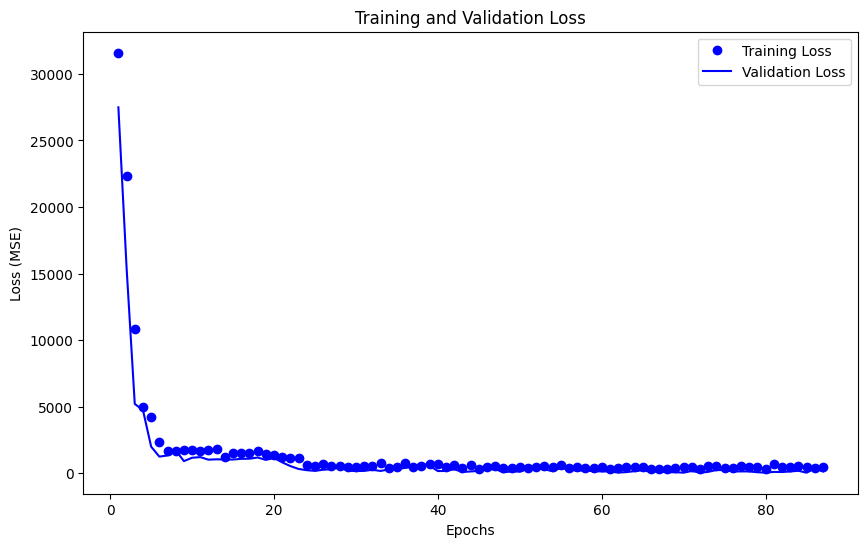

Training history plot generated.
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

 Transformer-based Fusion Model Performance (500m):
R² Train: -0.9606 | RMSE Train: 95.6076 | MAE Train: 72.2531 | SMAPE Train: 37.81%
R² Test: 0.9604 | RMSE Test: 15.7421 | MAE Test: 13.2640 | SMAPE Test: 9.52%

Starting Permutation Feature Importance Analysis...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Baseline R² on test set: 0.9604
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

--- Feature Importance (Permutation) ---
MLP: 2.0183
CNN: 0.0023
GNN: 0.0001


In [3]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LayerNormalization, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.utils import Sequence

# A note on the Python environment:
# This script assumes you have the following libraries installed:
# pandas, numpy, glob, os, rasterio, scipy, scikit-learn, tensorflow, matplotlib
# If not, you can install them using pip:
# pip install pandas numpy rasterio scipy scikit-learn tensorflow matplotlib

BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.buffer_meters = buffer_meters
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )
        
        return (batch_cnn, batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define Transformer-based Fusion Model ==================== #
def build_transformer_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # Inputs for all branches
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- CNN Branch ---
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_embedding = Flatten(name="cnn_embedding_flatten")(cnn_branch)
    
    # --- MLP Branch ---
    mlp_embedding = Dense(128, activation="relu")(mlp_input)
    mlp_embedding = Dense(64, activation="relu", name="mlp_embedding")(mlp_embedding)

    # --- GNN Branch ---
    gnn_embedding = Dense(128, activation="relu")(gnn_input)
    gnn_embedding = Dense(64, activation="relu", name="gnn_embedding")(gnn_embedding)

    # --- Transformer Fusion ---
    # To feed into the transformer, we need to make all embeddings have the same dimension.
    # Let's use a dense layer to project them to a common size.
    projection_dim = 64
    cnn_proj = Dense(projection_dim)(cnn_embedding)
    mlp_proj = Dense(projection_dim)(mlp_embedding)
    gnn_proj = Dense(projection_dim)(gnn_embedding)

    # Stack the embeddings to create a sequence for the transformer
    # Shape becomes (None, 3, projection_dim)
    # Corrected code to use Keras-compatible operations
    cnn_expanded = Reshape((1, projection_dim))(cnn_proj)
    mlp_expanded = Reshape((1, projection_dim))(mlp_proj)
    gnn_expanded = Reshape((1, projection_dim))(gnn_proj)
    embeddings = Concatenate(axis=1)([cnn_expanded, mlp_expanded, gnn_expanded])

    # Transformer Encoder block
    transformer_output = MultiHeadAttention(
        num_heads=4,
        key_dim=projection_dim
    )(embeddings, embeddings)
    transformer_output = Dropout(0.2)(transformer_output)
    transformer_output = LayerNormalization(epsilon=1e-6)(embeddings + transformer_output)
    
    # The output from the transformer is a sequence of 3 vectors.
    # We flatten this for the final prediction layer.
    transformer_output_flattened = Flatten()(transformer_output)
    
    # Final dense layers for prediction
    f = Dense(128, activation="relu")(transformer_output_flattened)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# --- NEW FUNCTION: Calculate SMAPE ---
def calculate_smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Avoid division by zero by replacing it with a very small number
    # This assumes that a true and predicted value of 0 should result in 0 error.
    # We'll use a small epsilon to handle cases where the denominator is 0.
    smape_val = np.mean(numerator / (denominator + K.epsilon())) * 100
    
    return smape_val


# --- MODIFIED FUNCTION: Evaluate Model to include MAE and SMAPE ---
def evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    """
    Evaluates the model on given data and returns R², RMSE, MAE, SMAPE, and predictions.
    """
    num_samples = len(y_true)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        smape = calculate_smape(y_true, y_pred)
        return r2, rmse, mae, smape

# --- MODIFIED FUNCTION: Permutation Importance to handle new metrics ---
def calculate_permutation_importance(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4):
    """
    Calculates permutation feature importance for the three model branches.
    """
    print("\nStarting Permutation Feature Importance Analysis...")
    # Get baseline R² on the unshuffled data
    baseline_r2, _, _, _ = evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    print(f"Baseline R² on test set: {baseline_r2:.4f}")

    importance = {}
    
    # Permute CNN input
    shuffled_indices = np.random.permutation(len(y_true))
    coords_shuffled = coords[shuffled_indices]
    shuffled_r2, _, _, _ = evaluate_model(model, coords_shuffled, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['CNN'] = baseline_r2 - shuffled_r2
    
    # Permute MLP input
    shuffled_mlp_data = mlp_data.copy()
    np.random.shuffle(shuffled_mlp_data)
    shuffled_r2, _, _, _ = evaluate_model(model, coords, shuffled_mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['MLP'] = baseline_r2 - shuffled_r2

    # Permute GNN input
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2, _, _, _ = evaluate_model(model, coords, mlp_data, shuffled_gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['GNN'] = baseline_r2 - shuffled_r2

    return importance

# --- NEW FUNCTION: Plotting the training history ---
def plot_training_history(history):
    """
    Plots the training and validation loss over the epochs.
    """
    # Get the loss and validation loss from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()
    print("Training history plot generated.")

# ==================== Run the Analysis ==================== #

print("\n" + "="*80)
print(f"Analyzing Transformer-based Fusion Model for BUFFER_METERS = {BUFFER_METERS}m")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)

# Calculate CNN patch shape based on the current buffer size
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

mlp_input_dim = mlp_train.shape[1]

model = build_transformer_fusion_model(cnn_patch_shape, gnn_input_dim, mlp_input_dim)
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    coords=coords_train, mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=True
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

plot_training_history(history)

# ==================== 8. Evaluate & Perform Feature Importance ==================== #
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))
mae_train = mean_absolute_error(y_train[:len(y_pred_train)], y_pred_train)
smape_train = calculate_smape(y_train[:len(y_pred_train)], y_pred_train)

r2_test, rmse_test, mae_test, smape_test = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, BUFFER_METERS, batch_size=batch_size)

print(f"\n Transformer-based Fusion Model Performance ({BUFFER_METERS}m):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f} | MAE Train: {mae_train:.4f} | SMAPE Train: {smape_train:.2f}%")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f} | MAE Test: {mae_test:.4f} | SMAPE Test: {smape_test:.2f}%")

# Calculate and print feature importance
feature_importance = calculate_permutation_importance(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, BUFFER_METERS, batch_size=batch_size)
print("\n--- Feature Importance (Permutation) ---")
sorted_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, score in sorted_importance:
    print(f"{feature}: {score:.4f}")


In [1]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LayerNormalization, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.utils import Sequence

# A note on the Python environment:
# This script assumes you have the following libraries installed:
# pandas, numpy, glob, os, rasterio, scipy, scikit-learn, tensorflow, matplotlib
# If not, you can install them using pip:
# pip install pandas numpy rasterio scipy scikit-learn tensorflow matplotlib

BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.buffer_meters = buffer_meters
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )
        
        return (batch_cnn, batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define Transformer-based Fusion Model ==================== #
def build_transformer_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # Inputs for all branches
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- CNN Branch ---
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_embedding = Flatten(name="cnn_embedding_flatten")(cnn_branch)
    
    # --- MLP Branch ---
    mlp_embedding = Dense(128, activation="relu")(mlp_input)
    mlp_embedding = Dense(64, activation="relu", name="mlp_embedding")(mlp_embedding)

    # --- GNN Branch ---
    gnn_embedding = Dense(128, activation="relu")(gnn_input)
    gnn_embedding = Dense(64, activation="relu", name="gnn_embedding")(gnn_embedding)

    # --- Transformer Fusion ---
    # To feed into the transformer, we need to make all embeddings have the same dimension.
    # Let's use a dense layer to project them to a common size.
    projection_dim = 64
    cnn_proj = Dense(projection_dim)(cnn_embedding)
    mlp_proj = Dense(projection_dim)(mlp_embedding)
    gnn_proj = Dense(projection_dim)(gnn_embedding)

    # Stack the embeddings to create a sequence for the transformer
    # Shape becomes (None, 3, projection_dim)
    # Corrected code to use Keras-compatible operations
    cnn_expanded = Reshape((1, projection_dim))(cnn_proj)
    mlp_expanded = Reshape((1, projection_dim))(mlp_proj)
    gnn_expanded = Reshape((1, projection_dim))(gnn_proj)
    embeddings = Concatenate(axis=1)([cnn_expanded, mlp_expanded, gnn_expanded])

    # Transformer Encoder block
    transformer_output = MultiHeadAttention(
        num_heads=4,
        key_dim=projection_dim
    )(embeddings, embeddings)
    transformer_output = Dropout(0.2)(transformer_output)
    transformer_output = LayerNormalization(epsilon=1e-6)(embeddings + transformer_output)
    
    # The output from the transformer is a sequence of 3 vectors.
    # We flatten this for the final prediction layer.
    transformer_output_flattened = Flatten()(transformer_output)
    
    # Final dense layers for prediction
    f = Dense(128, activation="relu")(transformer_output_flattened)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# --- NEW FUNCTION: Calculate SMAPE ---
def calculate_smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Avoid division by zero by replacing it with a very small number
    # This assumes that a true and predicted value of 0 should result in 0 error.
    # We'll use a small epsilon to handle cases where the denominator is 0.
    smape_val = np.mean(numerator / (denominator + K.epsilon())) * 100
    
    return smape_val


# --- MODIFIED FUNCTION: Evaluate Model to include MAE and SMAPE ---
def evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    """
    Evaluates the model on given data and returns R², RMSE, MAE, SMAPE, and predictions.
    """
    num_samples = len(y_true)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        smape = calculate_smape(y_true, y_pred)
        return r2, rmse, mae, smape

# --- MODIFIED FUNCTION: Permutation Importance to handle new metrics ---
def calculate_permutation_importance(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4):
    """
    Calculates permutation feature importance for the three model branches.
    """
    print("\nStarting Permutation Feature Importance Analysis...")
    # Get baseline R² on the unshuffled data
    baseline_r2, _, _, _ = evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    print(f"Baseline R² on test set: {baseline_r2:.4f}")

    importance = {}
    
    # Permute CNN input
    shuffled_indices = np.random.permutation(len(y_true))
    coords_shuffled = coords[shuffled_indices]
    shuffled_r2, _, _, _ = evaluate_model(model, coords_shuffled, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['CNN'] = baseline_r2 - shuffled_r2
    
    # Permute MLP input
    shuffled_mlp_data = mlp_data.copy()
    np.random.shuffle(shuffled_mlp_data)
    shuffled_r2, _, _, _ = evaluate_model(model, coords, shuffled_mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['MLP'] = baseline_r2 - shuffled_r2

    # Permute GNN input
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2, _, _, _ = evaluate_model(model, coords, mlp_data, shuffled_gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['GNN'] = baseline_r2 - shuffled_r2

    return importance

# --- NEW FUNCTION: Plotting the training history ---
def plot_training_history(history):
    """
    Plots the training and validation loss over the epochs.
    """
    # Get the loss and validation loss from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()
    print("Training history plot generated.")

# ==================== Run the Analysis ==================== #

print("\n" + "="*80)
print(f"Analyzing Transformer-based Fusion Model for BUFFER_METERS = {BUFFER_METERS}m")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)

# Calculate CNN patch shape based on the current buffer size
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

mlp_input_dim = mlp_train.shape[1]

model = build_transformer_fusion_model(cnn_patch_shape, gnn_input_dim, mlp_input_dim)

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    coords=coords_train, mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=True
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=0,
    callbacks=[early_stopping],
    validation_data=train_generator
)


Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif

Analyzing Transformer-based Fusion Model for BUFFER_METERS = 500m


In [2]:
model.save("Model1.keras")


In [31]:
from tensorflow.keras.models import load_model
model = load_model('Model1.keras')



Generating predictions for the test set...

Generating predictions for the test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Creating 3D subplots of True vs. Predicted RI...


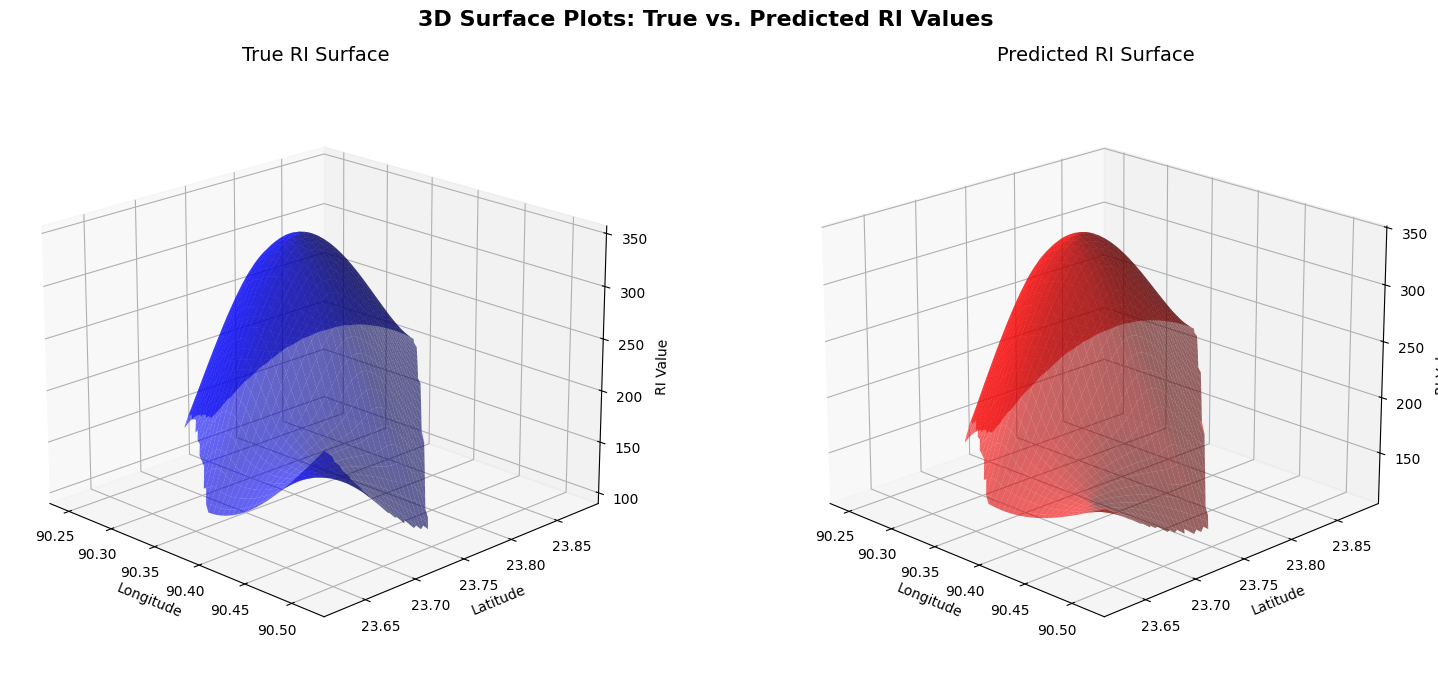

Two-subplot 3D plot generated. Close the plot window to continue.


In [18]:

# --- MODIFIED FUNCTION: Evaluate Model to include MAE and SMAPE ---
def evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    """
    Evaluates the model on given data and returns R², RMSE, MAE, SMAPE, and predictions.
    This function now includes the 'return_preds' argument to control its output.
    """
    num_samples = len(y_true)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        smape = calculate_smape(y_true, y_pred)
        return r2, rmse, mae, smape

# ==================== 8. Visualize Results with 3D Surface Plot ==================== #
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# --- Get Predictions for the Test Set ---
print("\n" + "="*80)
print("Generating predictions for the test set...")
print("="*80)

# ==================== 8. Visualize Results with 3D Subplots ==================== #
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# --- Get Predictions for the Test Set ---
print("\n" + "="*80)
print("Generating predictions for the test set...")
print("="*80)

# The evaluate_model function returns predictions when return_preds is True
y_pred_test = evaluate_model(
    model,
    coords=coords_test,
    mlp_data=mlp_test,
    gnn_data=gnn_test,
    y_true=y_test,
    raster_paths=raster_paths,
    buffer_meters=BUFFER_METERS,
    batch_size=batch_size,
    return_preds=True
)

# ==================== 9. Create 3D Subplots ==================== #
print("\n" + "="*80)
print("Creating 3D subplots of True vs. Predicted RI...")
print("="*80)

# Create a figure with two 3D subplots
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(16, 7),
    subplot_kw={"projection": "3d"}
)

# Get the longitude and latitude from the test data
lon_test = test_orig['Long'].values
lat_test = test_orig['Lat'].values

# Create a grid for interpolation to create smooth surfaces
lon_grid, lat_grid = np.meshgrid(
    np.linspace(lon_test.min(), lon_test.max(), 100),
    np.linspace(lat_test.min(), lat_test.max(), 100)
)

# Interpolate the true RI values onto the grid
true_surface = griddata(
    (lon_test, lat_test),
    y_test,
    (lon_grid, lat_grid),
    method='cubic'
)

# Interpolate the predicted RI values onto the grid
predicted_surface = griddata(
    (lon_test, lat_test),
    y_pred_test,
    (lon_grid, lat_grid),
    method='cubic'
)

# Plot the true RI surface on the first subplot (ax1)
surf_true = ax1.plot_surface(
    lon_grid,
    lat_grid,
    true_surface,
    color='blue',
    alpha=0.6,
    rcount=50,
    ccount=50
)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_zlabel('RI Value')
ax1.set_title('True RI Surface', fontsize=14)

# Plot the predicted RI surface on the second subplot (ax2)
surf_pred = ax2.plot_surface(
    lon_grid,
    lat_grid,
    predicted_surface,
    color='red',
    alpha=0.6,
    rcount=50,
    ccount=50
)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_zlabel('RI Value')
ax2.set_title('Predicted RI Surface', fontsize=14)

# Adjust the camera view for both subplots for a consistent look
ax1.view_init(elev=20, azim=-45)
ax2.view_init(elev=20, azim=-45)

# Add a main title for the entire figure
fig.suptitle(
    '3D Surface Plots: True vs. Predicted RI Values',
    fontsize=16,
    fontweight='bold'
)

# Show the plot
plt.tight_layout()
plt.show()

print("Two-subplot 3D plot generated. Close the plot window to continue.")


Original dataset size: 17 rows
Training set size: 105 rows
Test set size: 12 rows
Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif

Analyzing Transformer-based Fusion Model for BUFFER_METERS = 500m

Generating predictions for the test set...
Input batch shapes: CNN: (4, 100, 100, 26), MLP: (4, 15), GNN: (4, 105)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Input batch shapes: CNN: (4, 100, 100, 26), MLP: (4, 15), GNN: (4, 105)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Input batch shapes: CNN: (4, 100, 100, 26), MLP: (4, 15), GNN: (4, 105)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Creating 3D subplots of True vs. Predicted RI...


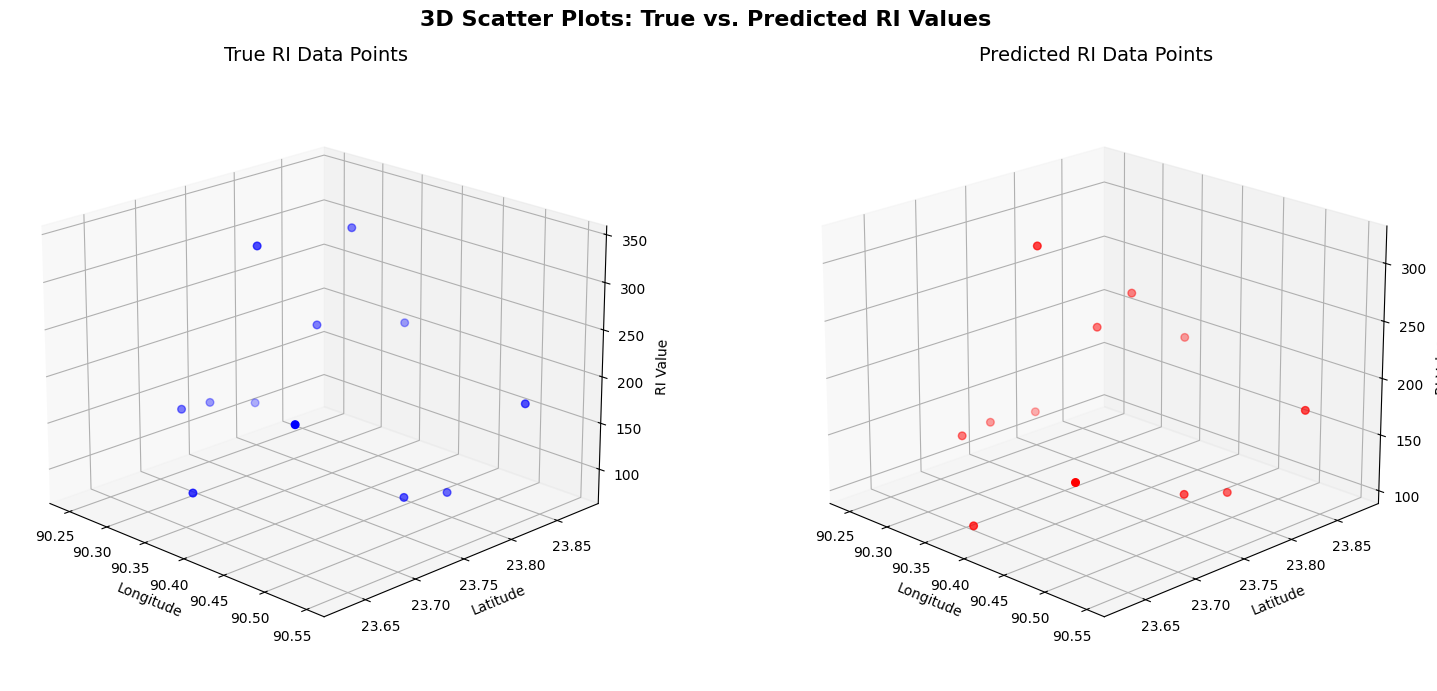

In [38]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LayerNormalization, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.utils import Sequence

# A note on the Python environment:
# This script assumes you have the following libraries installed:
# pandas, numpy, glob, os, rasterio, scipy, scikit-learn, tensorflow, matplotlib
# If not, you can install them using pip:
# pip install pandas numpy rasterio scipy scikit-learn tensorflow matplotlib

BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
# The test set size is determined by the size of the original data minus the training sample size.
# To ensure at least 24 points in the test set, you must have at least 24 rows in your 'orig' dataframe.
# Assuming 'orig' has at least 34 rows, this split will result in a test set of 24 rows.
train_orig = orig.sample(5, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

print(f"Original dataset size: {len(orig)} rows")
print(f"Training set size: {len(train_combined)} rows")
print(f"Test set size: {len(test_orig)} rows")


# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.buffer_meters = buffer_meters
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )
        
        return (batch_cnn, batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define Transformer-based Fusion Model ==================== #
def build_transformer_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # Inputs for all branches
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- CNN Branch ---
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_embedding = Flatten(name="cnn_embedding_flatten")(cnn_branch)
    
    # --- MLP Branch ---
    mlp_embedding = Dense(128, activation="relu")(mlp_input)
    mlp_embedding = Dense(64, activation="relu", name="mlp_embedding")(mlp_embedding)

    # --- GNN Branch ---
    gnn_embedding = Dense(128, activation="relu")(gnn_input)
    gnn_embedding = Dense(64, activation="relu", name="gnn_embedding")(gnn_embedding)

    # --- Transformer Fusion ---
    # To feed into the transformer, we need to make all embeddings have the same dimension.
    # Let's use a dense layer to project them to a common size.
    projection_dim = 64
    cnn_proj = Dense(projection_dim)(cnn_embedding)
    mlp_proj = Dense(projection_dim)(mlp_embedding)
    gnn_proj = Dense(projection_dim)(gnn_embedding)

    # Stack the embeddings to create a sequence for the transformer
    # Shape becomes (None, 3, projection_dim)
    # Corrected code to use Keras-compatible operations
    cnn_expanded = Reshape((1, projection_dim))(cnn_proj)
    mlp_expanded = Reshape((1, projection_dim))(mlp_proj)
    gnn_expanded = Reshape((1, projection_dim))(gnn_proj)
    embeddings = Concatenate(axis=1)([cnn_expanded, mlp_expanded, gnn_expanded])

    # Transformer Encoder block
    transformer_output = MultiHeadAttention(
        num_heads=4,
        key_dim=projection_dim
    )(embeddings, embeddings)
    transformer_output = Dropout(0.2)(transformer_output)
    transformer_output = LayerNormalization(epsilon=1e-6)(embeddings + transformer_output)
    
    # The output from the transformer is a sequence of 3 vectors.
    # We flatten this for the final prediction layer.
    transformer_output_flattened = Flatten()(transformer_output)
    
    # Final dense layers for prediction
    f = Dense(128, activation="relu")(transformer_output_flattened)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# --- NEW FUNCTION: Calculate SMAPE ---
def calculate_smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Avoid division by zero by replacing it with a very small number
    # This assumes that a true and predicted value of 0 should result in 0 error.
    # We'll use a small epsilon to handle cases where the denominator is 0.
    smape_val = np.mean(numerator / (denominator + K.epsilon())) * 100
    
    return smape_val


# --- CORRECTED FUNCTION: Evaluate Model to include MAE and SMAPE and return_preds ---
def evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    """
    Evaluates the model on given data and returns R², RMSE, MAE, SMAPE, and predictions.
    This function now includes the 'return_preds' argument to control its output.
    """
    num_samples = len(y_true)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        # This print statement was moved to the correct location.
        print(f"Input batch shapes: CNN: {batch_cnn.shape}, MLP: {batch_mlp.shape}, GNN: {batch_gnn.shape}")
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        smape = calculate_smape(y_true, y_pred)
        return r2, rmse, mae, smape

# --- MODIFIED FUNCTION: Permutation Importance to handle new metrics ---
def calculate_permutation_importance(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4):
    """
    Calculates permutation feature importance for the three model branches.
    """
    print("\nStarting Permutation Feature Importance Analysis...")
    # Get baseline R² on the unshuffled data
    baseline_r2, _, _, _ = evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    print(f"Baseline R² on test set: {baseline_r2:.4f}")

    importance = {}
    
    # Permute CNN input
    shuffled_indices = np.random.permutation(len(y_true))
    coords_shuffled = coords[shuffled_indices]
    shuffled_r2, _, _, _ = evaluate_model(model, coords_shuffled, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['CNN'] = baseline_r2 - shuffled_r2
    
    # Permute MLP input
    shuffled_mlp_data = mlp_data.copy()
    np.random.shuffle(shuffled_mlp_data)
    shuffled_r2, _, _, _ = evaluate_model(model, coords, shuffled_mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['MLP'] = baseline_r2 - shuffled_r2

    # Permute GNN input
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2, _, _, _ = evaluate_model(model, coords, mlp_data, shuffled_gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['GNN'] = baseline_r2 - shuffled_r2

    return importance

# --- NEW FUNCTION: Plotting the training history ---
def plot_training_history(history):
    """
    Plots the training and validation loss over the epochs.
    """
    # Get the loss and validation loss from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()
    print("Training history plot generated.")

# ==================== 6. Run the Analysis and Training ==================== #
print("\n" + "="*80)
print(f"Analyzing Transformer-based Fusion Model for BUFFER_METERS = {BUFFER_METERS}m")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)

# Calculate CNN patch shape based on the current buffer size
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

mlp_input_dim = mlp_train.shape[1]

# Build the model with the current dimensions
model = build_transformer_fusion_model(cnn_patch_shape, gnn_input_dim, mlp_input_dim)

# ==================== 7. Create Data Generators and Train Model ==================== #
train_generator = DataGenerator(
    coords=coords_train, mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=0,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# ==================== 8. Visualize Results with 3D Subplots ==================== #
# --- Get Predictions for the Test Set ---
print("\n" + "="*80)
print("Generating predictions for the test set...")
print("="*80)

# The evaluate_model function returns predictions when return_preds is True
y_pred_test = evaluate_model(
    model,
    coords=coords_test,
    mlp_data=mlp_test,
    gnn_data=gnn_test,
    y_true=y_test,
    raster_paths=raster_paths,
    buffer_meters=BUFFER_METERS,
    batch_size=batch_size,
    return_preds=True
)

# ==================== 9. Create 3D Subplots ==================== #
print("\n" + "="*80)
print("Creating 3D subplots of True vs. Predicted RI...")
print("="*80)

# Create a figure with two 3D subplots
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(16, 7),
    subplot_kw={"projection": "3d"}
)

# Get the longitude and latitude from the test data
lon_test = test_orig['Long'].values
lat_test = test_orig['Lat'].values

# Plot the true RI points on the first subplot (ax1)
ax1.scatter(
    lon_test,
    lat_test,
    y_test,
    c='blue',
    s=30
)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_zlabel('RI Value')
ax1.set_title('True RI Data Points', fontsize=14)

# Plot the predicted RI points on the second subplot (ax2)
ax2.scatter(
    lon_test,
    lat_test,
    y_pred_test,
    c='red',
    s=30
)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_zlabel('RI Value')
ax2.set_title('Predicted RI Data Points', fontsize=14)

# Adjust the camera view for both subplots for a consistent look
ax1.view_init(elev=20, azim=-45)
ax2.view_init(elev=20, azim=-45)

# Add a main title for the entire figure
fig.suptitle(
    '3D Scatter Plots: True vs. Predicted RI Values',
    fontsize=16,
    fontweight='bold'
)

# Show the plot
plt.tight_layout()
plt.show()


In [52]:
df = pd.DataFrame({
    "Longitude": lon_test,
    "Latitude": lat_test,
    "YTest": y_test[:12],
    "YPred": y_pred_test})


In [53]:
df


,Longitude,Latitude,YTest,YPred
0,90.245390,23.802571,133.26,117.471970
1,90.246581,23.754298,115.16,122.809937
2,90.277077,23.702157,107.92,134.304443
3,90.388647,23.628000,126.51,107.897072
4,90.350573,23.877666,147.44,189.752350
5,90.342201,23.826986,120.30,242.047165
6,90.339601,23.792572,120.94,220.452911
7,90.359274,23.716059,202.03,316.487915
8,90.482538,23.764005,320.26,116.163559
9,90.484506,23.808202,225.63,103.958298


In [54]:
df.to_csv("PredTest.csv")


In [39]:
model.save("Model1.keras")


In [48]:
y_test


array([133.26, 115.16, 107.92, 126.51, 147.44, 120.3 , 120.94, 202.03,
       320.26, 225.63, 340.09, 386.12,  92.84,  81.26, 187.61, 232.42,
       231.42])

In [49]:
y_pred_test


array([117.47197, 122.80994, 134.30444, 107.89707, 189.75235, 242.04716,
       220.45291, 316.4879 , 116.16356, 103.9583 , 185.55151, 179.07095],
      dtype=float32)

In [51]:
lon_test.shape


(12,)

# Model load

In [3]:
models_dir = 'models/transformer'
tf_save_path = os.path.join(models_dir, 'transformer_cnn_gnn_mlp5.keras')

model = tf.keras.models.load_model(tf_save_path)
model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 100, 100,  │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 50, 50,    │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 50, 50,    │     18,496 │ max_pooling2d_30… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 94)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 25, 25,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 128)       │      2,048 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_106 (Dense)   │ (None, 128)       │     12,160 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_embedding_flat… │ (None, 40000)     │          0 │ max_pooling2d_31… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_embedding       │ (None, 64)        │      8,256 │ dense_105[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_embedding       │ (None, 64)        │      8,256 │ dense_106[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 64)        │  2,560,064 │ cnn_embedding_fl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_108 (Dense)   │ (None, 64)        │      4,160 │ mlp_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_109 (Dense)   │ (None, 64)        │      4,160 │ gnn_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_45          │ (None, 1, 64)     │          0 │ dense_107[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_46          │ (None, 1, 64)     │          0 │ dense_108[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_47          │ (None, 1, 64)     │          0 │ dense_109[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 8,173,925 (31.18 MB)

 Trainable params: 2,724,641 (10.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,449,284 (20.79 MB)

In [18]:
models_dir = 'models'
transformer_dir = os.path.join(models_dir, 'transformer')

history_save_path = os.path.join(transformer_dir, 'training_history.pkl')
print(f"Saving training history to {history_save_path}...")
with open(history_save_path, 'wb') as f:
    pickle.dump(history.history, f)

metrics_save_path = os.path.join(transformer_dir, 'test_metrics.pkl')
print(f"Saving test metrics to {metrics_save_path}...")
test_metrics = {'r2_test': r2_test, 'rmse_test': rmse_test}
with open(metrics_save_path, 'wb') as f:
    pickle.dump(test_metrics, f)

generator_params_path = os.path.join(transformer_dir, 'generator_params.pkl')
generator_params = {
    'coords_train': coords_train,
    'mlp_train': mlp_train,
    'gnn_train': gnn_train,
    'y_train': y_train,
    'coords_test': coords_test,
    'mlp_test': mlp_test,
    'gnn_test': gnn_test,
    'y_test': y_test,
    'raster_paths': raster_paths,
    'BUFFER_METERS': BUFFER_METERS,
    'batch_size': batch_size
}
with open(generator_params_path, 'wb') as f:
    pickle.dump(generator_params, f)
print("Successfully saved generator parameters.")


Saving training history to models/transformer/training_history.pkl...
Saving test metrics to models/transformer/test_metrics.pkl...
Successfully saved generator parameters.


# Model Metrics

In [9]:
from sklearn.model_selection import train_test_split
# Load the full combined dataset and drop the non-numeric columns
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")
combined_data = pd.concat([river_100, orig], ignore_index=True)
drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')
# Prepare the data for the MLP and GNN branches for the entire dataset
coords_all = combined_data[['Long', 'Lat']].values
dist_mat_all = distance_matrix(coords_all, coords_all)
gnn_all = np.exp(-dist_mat_all/10)
scaler = StandardScaler()
mlp_all = scaler.fit_transform(combined_data[numeric_cols])
y_all = combined_data['RI'].values
# Re-create the Train/Test split to get the exact data for the 5th fold
# Single train/test split (80/20)
if True:  # Single train/test split
    if fold == 4: # Folds are 0-indexed, so the 5th fold is at index 4
        # Split the data for the current fold
        coords_val_fold = coords_all[val_index]
        mlp_val_fold = mlp_all[val_index]
        y_val_fold = y_all[val_index]
        # GNN validation data is the distances of validation points to training points
        gnn_val_fold = gnn_all[val_index][:, train_index]
        break
# This variable is needed by the evaluation function
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")
BUFFER_METERS = 500
batch_size = 4


In [13]:
# ==================== 1. Custom Metric Function ==================== #
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    
    Args:
        y_true (np.array): The true values.
        y_pred (np.array): The predicted values.
        
    Returns:
        float: The SMAPE value in percentage.
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Avoid division by zero by setting a small epsilon value
    denominator[denominator == 0] = 1e-10
    return np.mean(numerator / denominator) * 100

# ==================== 2. Evaluation Function ==================== #
def evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4):
    """
    Evaluates the model on given data and returns R², RMSE, MAE, and SMAPE.
    
    NOTE: This function assumes `extract_patch_for_generator` is available in the environment.
    """
    num_samples = len(y_true)
    y_pred_list = []
    
    # Pre-calculate patch size from the first raster
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    # Extract patches and make predictions in batches
    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    # Calculate all metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    
    return r2, rmse, mae, smape_val


# ==================== 4. Calculate Metrics and Create DataFrame ==================== #
print("\nCalculating metrics for the loaded model (Fold 5)...")

# Call the evaluation function with the assumed data
r2, rmse, mae, smape_val = evaluate_model(
    model, 
    coords_val_fold, 
    mlp_val_fold, 
    gnn_val_fold, 
    y_val_fold, 
    raster_paths, 
    BUFFER_METERS, 
    batch_size
)

# Create a dictionary to hold the results
results = {
    'R²': r2,
    'RMSE': rmse,
    'MAE': mae,
    'SMAPE': smape_val
}

# Create a DataFrame from the results
metrics_df = pd.DataFrame([results], index=['Transformer CNN GNN MLP']).T.round(4)

metrics_df



Calculating metrics for the loaded model (Fold 5)...


ValueError: Input 2 of layer "functional" is incompatible with the layer: expected shape=(None, 110), found shape=(4, 94)

# Ground Truth & Predicton

In [10]:
import numpy as np
import rasterio
from rasterio.windows import Window
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
# NOTE: The `model` variable and the `extract_patch_for_generator` function
# are assumed to be loaded in your environment from the previous steps.
# ==================== 1. Evaluation Function to get Predictions ==================== #
def evaluate_model_for_predictions(model, coords, mlp_data, gnn_data, raster_paths, buffer_meters, batch_size=4):
    """
    Evaluates the model on given data and returns the predicted values.
    
    NOTE: This function assumes `extract_patch_for_generator` is available in the environment.
    """
    num_samples = len(coords)
    y_pred_list = []
    
    # Pre-calculate patch size from the first raster
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y
    # Extract patches and make predictions in batches
    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    return y_pred
# ==================== 2. Plotting Function ==================== #
def plot_density_results(coords, y_true, y_pred):
    """
    Creates a single figure with two 2D density plots (heatmaps) for visualization.
    
    Args:
        coords (np.array): The coordinates (longitude, latitude).
        y_true (np.array): The true RI values.
        y_pred (np.array): The predicted RI values.
    """
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # First subplot for True RI values (density plot)
    hist1 = ax1.hist2d(coords[:, 0], coords[:, 1], bins=20, weights=y_true, cmap='viridis')
    ax1.set_title('True RI Values Density')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    fig.colorbar(hist1[3], ax=ax1, label='Average RI Value')
    
    # Second subplot for Predicted RI values (density plot)
    hist2 = ax2.hist2d(coords[:, 0], coords[:, 1], bins=20, weights=y_pred, cmap='viridis')
    ax2.set_title('Predicted RI Values Density')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    fig.colorbar(hist2[3], ax=ax2, label='Average RI Value')
    
    plt.tight_layout()
    plt.show()
    print("\nDensity plots generated successfully.")
# ==================== 3. Prepare Data for Evaluation (Fold 5) ==================== #
print("Loading and preparing data for evaluation...")
# Load the full combined dataset
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")
combined_data = pd.concat([river_100, orig], ignore_index=True)
drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')
# Prepare the data for the MLP and GNN branches
coords_all = combined_data[['Long', 'Lat']].values
dist_mat_all = distance_matrix(coords_all, coords_all)
gnn_all = np.exp(-dist_mat_all/10)
scaler = StandardScaler()
mlp_all = scaler.fit_transform(combined_data[numeric_cols])
y_all = combined_data['RI'].values
# Re-create the Train/Test split to get the exact data for the 5th fold
# Single train/test split (80/20)
if True:  # Single train/test split
    if fold == 4: # Folds are 0-indexed, so the 5th fold is at index 4
        coords_val_fold = coords_all[val_index]
        mlp_val_fold = mlp_all[val_index]
        y_val_fold = y_all[val_index]
        gnn_val_fold = gnn_all[val_index][:, train_index]
        break
# This variable is needed by the evaluation function
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")
print("Data for Fold 5 is now ready.")
# ==================== 4. Get Predictions and Generate Plots ==================== #
print("\nGetting predictions and generating density plots...")
# NOTE: This call will fail if the 'model' object is not loaded or the 
# `extract_patch_for_generator` function is not defined.
y_pred = evaluate_model_for_predictions(
    model, 
    coords_val_fold, 
    mlp_val_fold, 
    gnn_val_fold, 
    raster_paths, 
    BUFFER_METERS, 
    batch_size
)
# Generate the 2D density plots for visual comparison
plot_density_results(coords_val_fold, y_val_fold, y_pred)


Loading and preparing data for evaluation...
Data for Fold 5 is now ready.

Getting predictions and generating density plots...


ValueError: Input 2 of layer "functional" is incompatible with the layer: expected shape=(None, 110), found shape=(4, 94)

In [11]:
import numpy as np
import rasterio
from rasterio.windows import Window
from sklearn.model_selection import TrainTestSplit
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob

# NOTE: The `model` variable and the `extract_patch_for_generator` function
# are assumed to be loaded in your environment from the previous steps.

# ==================== 1. Evaluation Function to get Predictions ==================== #
def evaluate_model_for_predictions(model, coords, mlp_data, gnn_data, raster_paths, buffer_meters, batch_size=4):
    """
    Evaluates the model on given data and returns the predicted values.
    
    NOTE: This function assumes `extract_patch_for_generator` is available in the environment.
    """
    num_samples = len(coords)
    y_pred_list = []
    
    # Pre-calculate patch size from the first raster
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    # Extract patches and make predictions in batches
    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    return y_pred

# ==================== 2. Plotting Function ==================== #
def plot_3d_area_results(coords, y_true, y_pred):
    """
    Creates a single figure with two 3D area plots for visualization.
    
    Args:
        coords (np.array): The coordinates (longitude, latitude).
        y_true (np.array): The true RI values.
        y_pred (np.array): The predicted RI values.
    """
    # Create a figure with two subplots side-by-side
    fig = plt.figure(figsize=(16, 7))
    
    # Create a grid for the surface plot
    x_grid = np.linspace(coords[:, 0].min(), coords[:, 0].max(), 100)
    y_grid = np.linspace(coords[:, 1].min(), coords[:, 1].max(), 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Due to the sparse nature of the data, we need to interpolate the RI values
    # to create a continuous surface. This is a simple interpolation.
    from scipy.interpolate import griddata
    Z_true = griddata((coords[:, 0], coords[:, 1]), y_true, (X, Y), method='cubic')
    Z_pred = griddata((coords[:, 0], coords[:, 1]), y_pred, (X, Y), method='cubic')
    
    # First subplot for True RI values (3D surface plot)
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Z_true, cmap='magma', edgecolor='none')
    ax1.set_title('True RI')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_zlabel('RI')
    fig.colorbar(surf1, ax=ax1, shrink=0.3, aspect=10, label='RI Value')
    
    # Second subplot for Predicted RI values (3D surface plot)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, Y, Z_pred, cmap='magma', edgecolor='none')
    ax2.set_title('Predicted RI')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_zlabel('RI')
    fig.colorbar(surf2, ax=ax2, shrink=0.3, aspect=10, label='RI Value')
    
    plt.tight_layout()
    plt.savefig('transformer_fusion/RI True Predicted.png', dpi=500)
    plt.show()
    

# NOTE: This call will fail if the 'model' object is not loaded or the 
# `extract_patch_for_generator` function is not defined.
y_pred = evaluate_model_for_predictions(
    model, 
    coords_val_fold, 
    mlp_val_fold, 
    gnn_val_fold, 
    raster_paths, 
    BUFFER_METERS, 
    batch_size
)

plot_3d_area_results(coords_val_fold, y_val_fold, y_pred)


ValueError: Input 2 of layer "functional" is incompatible with the layer: expected shape=(None, 110), found shape=(4, 94)

In [12]:
import numpy as np
import rasterio
from rasterio.windows import Window
from sklearn.model_selection import TrainTestSplit
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob

# NOTE: The `model` variable and the `extract_patch_for_generator` function
# are assumed to be loaded in your environment from the previous steps.

# ==================== 1. Evaluation Function to get Predictions ==================== #
def evaluate_model_for_predictions(model, coords, mlp_data, gnn_data, raster_paths, buffer_meters, batch_size=4):
    """
    Evaluates the model on given data and returns the predicted values.
    
    NOTE: This function assumes `extract_patch_for_generator` is available in the environment.
    """
    num_samples = len(coords)
    y_pred_list = []
    
    # Pre-calculate patch size from the first raster
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    # Extract patches and make predictions in batches
    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    return y_pred

# ==================== 2. Plotting Function ==================== #
def plot_3d_area_results(coords, y_true, y_pred):
    """
    Creates a single figure with two 3D area plots for visualization.
    
    Args:
        coords (np.array): The coordinates (longitude, latitude).
        y_true (np.array): The true RI values.
        y_pred (np.array): The predicted RI values.
    """
    # Create a figure with two subplots side-by-side
    fig = plt.figure(figsize=(16, 7))
    
    # Create a grid for the surface plot
    x_grid = np.linspace(coords[:, 0].min(), coords[:, 0].max(), 100)
    y_grid = np.linspace(coords[:, 1].min(), coords[:, 1].max(), 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Due to the sparse nature of the data, we need to interpolate the RI values
    # to create a continuous surface. This is a simple interpolation.
    from scipy.interpolate import griddata
    Z_true = griddata((coords[:, 0], coords[:, 1]), y_true, (X, Y), method='cubic')
    Z_pred = griddata((coords[:, 0], coords[:, 1]), y_pred, (X, Y), method='cubic')
    
    # First subplot for True RI values (3D surface plot)
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Z_true, cmap='magma', edgecolor='none')
    ax1.set_title('True RI')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_zlabel('RI')
    ax1.grid(False)
    fig.colorbar(surf1, ax=ax1, shrink=0.3, aspect=10, label='')
    
    # Second subplot for Predicted RI values (3D surface plot)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, Y, Z_pred, cmap='magma', edgecolor='none')
    ax2.set_title('Predicted RI')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_zlabel('RI')
    ax2.grid(False) 
    fig.colorbar(surf2, ax=ax2, shrink=0.3, aspect=10, label='')
    
    plt.tight_layout()
    plt.savefig('transformer_fusion/RI True Predicted.png', dpi=500)
    plt.show()
    

# ==================== 3. Get Predictions and Generate Plots ==================== #
print("\nGetting predictions and generating 3D area plots...")

# NOTE: This call will fail if the 'model' object is not loaded or the 
# `extract_patch_for_generator` function is not defined.
y_pred = evaluate_model_for_predictions(
    model, 
    coords_val, 
    mlp_val, 
    gnn_val, 
    raster_paths, 
    BUFFER_METERS, 
    batch_size
)

# Generate the 3D area plots for visual comparison
plot_3d_area_results(coords_val_fold, y_val_fold, y_pred)



Getting predictions and generating 3D area plots...


NameError: name 'coords_val' is not defined

# Feature Importance (Permutation based)

In [21]:
'''
# ==================== 1. Load Data (Required for the analysis) ==================== #
# Note: This section is included to make the script runnable.
# It loads and preprocesses the data needed for the evaluation.
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# Collect ALL Rasters
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

# Prepare GNN & MLP Input
coords_test = test_orig[['Long','Lat']].values
coords_train = train_combined[['Long','Lat']].values # Need this for the gnn_test calculation
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
# The scaler must be fit on the training data and transform the test data
mlp_train_df = train_combined[numeric_cols].copy()
mlp_test_df = test_orig[numeric_cols].copy()
scaler.fit(mlp_train_df)
mlp_test = scaler.transform(mlp_test_df)
y_test = test_orig['RI'].values
BUFFER_METERS = 500
batch_size = 4
'''
# ==================== 2. Helper Functions (Required for the analysis) ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    for lon, lat in coords:
        channels = []
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

def evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4):
    """
    Evaluates the model on given data and returns R².
    """
    num_samples = len(y_true)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    r2 = r2_score(y_true, y_pred)
    return r2


# ==================== 3. Permutation Feature Importance Function ==================== #
def calculate_permutation_importance(model, coords, mlp_data, gnn_data, y_true, raster_paths, numeric_cols, buffer_meters, batch_size=4):
    """
    Calculates permutation feature importance for the three model branches
    and for each individual numeric feature.
    """
    print("\nStarting Permutation Feature Importance Analysis...")
    
    # Get baseline R² on the unshuffled data
    baseline_r2 = evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    print(f"Baseline R² on test set: {baseline_r2:.4f}\n")

    importance = {}
    
    # Permute CNN input (all rasters at once)
    print("Permuting CNN features...")
    shuffled_indices_cnn = np.random.permutation(len(y_true))
    coords_shuffled = coords[shuffled_indices_cnn]
    shuffled_r2 = evaluate_model(model, coords_shuffled, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['CNN_all_rasters'] = baseline_r2 - shuffled_r2
    
    # Permute GNN input
    print("Permuting GNN features...")
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2 = evaluate_model(model, coords, mlp_data, shuffled_gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['GNN_distance_matrix'] = baseline_r2 - shuffled_r2
    
    # Permute each MLP input feature individually
    print("Permuting individual numeric features...")
    for i, col in enumerate(numeric_cols):
        # Create a copy to shuffle a single column
        shuffled_mlp_data = mlp_data.copy()
        
        # Get the index of the column to shuffle in the numpy array
        mlp_data_df = pd.DataFrame(mlp_data, columns=numeric_cols)
        col_index = mlp_data_df.columns.get_loc(col)
        
        # Shuffle only the values for this specific column
        shuffled_col = shuffled_mlp_data[:, col_index].copy()
        np.random.shuffle(shuffled_col)
        shuffled_mlp_data[:, col_index] = shuffled_col
        
        # Evaluate model with the single shuffled feature
        shuffled_r2 = evaluate_model(model, coords, shuffled_mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
        importance[f'MLP_{col}'] = baseline_r2 - shuffled_r2

    return importance

# Calculate and print feature importance
feature_importance = calculate_permutation_importance(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, numeric_cols, BUFFER_METERS, batch_size=batch_size)
print("\n--- Feature Importance (Permutation) ---")
sorted_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, score in sorted_importance:
    print(f"{feature}: {score:.4f}")



Starting Permutation Feature Importance Analysis...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Baseline R² on test set: 0.9263

Permuting CNN features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Permuting GNN features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Permuting individual numeric features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [23]:
sorted_importance


[('CNN_all_rasters', 0.39284181206815405),
 ('MLP_CuR', 0.32994399051075984),
 ('MLP_PbR', 0.11027766123127214),
 ('MLP_num_industry', 0.04832869544755014),
 ('MLP_SandR', 0.033004081916877315),
 ('MLP_NiR', 0.0314893182391085),
 ('MLP_num_brick_field', 0.03145232869803616),
 ('MLP_SiltR', 0.02892056522489761),
 ('MLP_CdR', 0.021333433925694756),
 ('MLP_FeR', 0.017881122350473677),
 ('MLP_AsR', 0.01049627753838045),
 ('MLP_ClayR', 0.00721324416610214),
 ('MLP_CrR', 0.004125968237093991),
 ('MLP_hydro_dist_brick', 4.188700630791686e-08),
 ('MLP_hydro_dist_ind', -3.3172053215402286e-08),
 ('GNN_distance_matrix', -6.081436809357577e-06),
 ('MLP_MR', -0.000604768454415483)]

In [24]:
'''
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

coords_test = test_orig[['Long','Lat']].values
coords_train = train_combined[['Long','Lat']].values # Need this for the gnn_test calculation
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()

mlp_train_df = train_combined[numeric_cols].copy()
mlp_test_df = test_orig[numeric_cols].copy()
scaler.fit(mlp_train_df)
mlp_test = scaler.transform(mlp_test_df)
y_test = test_orig['RI'].values
BUFFER_METERS = 500
batch_size = 4
'''

def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    for lon, lat in coords:
        channels = []
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

def evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=4, shuffle_raster_idx=None):
    """
    Evaluates the model on given data and returns R².
    Includes an option to shuffle a single raster's features for importance calculation.
    """
    num_samples = len(y_true)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        if shuffle_raster_idx is not None:
            # Shuffle the patches for the specific raster channel
            shuffled_indices = np.random.permutation(len(batch_cnn))
            batch_cnn_shuffled_channel = batch_cnn[:, :, :, shuffle_raster_idx][shuffled_indices]
            batch_cnn[:, :, :, shuffle_raster_idx] = batch_cnn_shuffled_channel

        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    r2 = r2_score(y_true, y_pred)
    return r2


# ==================== 3. Permutation Feature Importance Function ==================== #
def calculate_permutation_importance(model, coords, mlp_data, gnn_data, y_true, raster_paths, numeric_cols, buffer_meters, batch_size=4):
    """
    Calculates permutation feature importance for the three model branches
    and for each individual numeric feature and raster.
    """
    print("\nStarting Permutation Feature Importance Analysis...")
    
    # Get baseline R² on the unshuffled data
    baseline_r2 = evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    print(f"Baseline R² on test set: {baseline_r2:.4f}\n")

    importance = {}
    
    # Permute CNN input (all rasters at once)
    print("Permuting CNN features (all rasters at once)...")
    shuffled_indices_cnn = np.random.permutation(len(y_true))
    coords_shuffled = coords[shuffled_indices_cnn]
    shuffled_r2 = evaluate_model(model, coords_shuffled, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['CNN_all_rasters'] = baseline_r2 - shuffled_r2
    
    # Permute each individual raster separately
    print("Permuting individual rasters...")
    for i, rfile in enumerate(raster_paths):
        raster_name = os.path.basename(rfile).split('.')[0]
        shuffled_r2 = evaluate_model(model, coords, mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size, shuffle_raster_idx=i)
        importance[f'CNN_{raster_name}'] = baseline_r2 - shuffled_r2
        print(f"  - Finished permutation for {raster_name}")

    # Permute GNN input
    print("\nPermuting GNN features...")
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2 = evaluate_model(model, coords, mlp_data, shuffled_gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
    importance['GNN_distance_matrix'] = baseline_r2 - shuffled_r2
    
    # Permute each MLP input feature individually
    print("Permuting individual numeric features...")
    for i, col in enumerate(numeric_cols):
        # Create a copy to shuffle a single column
        shuffled_mlp_data = mlp_data.copy()
        
        # Get the index of the column to shuffle in the numpy array
        mlp_data_df = pd.DataFrame(mlp_data, columns=numeric_cols)
        col_index = mlp_data_df.columns.get_loc(col)
        
        # Shuffle only the values for this specific column
        shuffled_col = shuffled_mlp_data[:, col_index].copy()
        np.random.shuffle(shuffled_col)
        shuffled_mlp_data[:, col_index] = shuffled_col
        
        # Evaluate model with the single shuffled feature
        shuffled_r2 = evaluate_model(model, coords, shuffled_mlp_data, gnn_data, y_true, raster_paths, buffer_meters, batch_size=batch_size)
        importance[f'MLP_{col}'] = baseline_r2 - shuffled_r2
        print(f"  - Finished permutation for {col}")

    return importance


feature_importance1 = calculate_permutation_importance(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, numeric_cols, BUFFER_METERS, batch_size=batch_size)
print("\n--- Feature Importance (Permutation) ---")
sorted_importance = sorted(feature_importance1.items(), key=lambda item: item[1], reverse=True)
for feature, score in sorted_importance:
    print(f"{feature}: {score:.4f}")



Starting Permutation Feature Importance Analysis...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Baseline R² on test set: 0.9263

Permuting CNN features (all rasters at once)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Permuting individual rasters...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
  - Finished permutation for bui
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
  - Finished permutation for ndsi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
  - Finished permutation for savi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
  - Finished permutation for ndbsi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
  - Finished permutation for ui
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
  - Finished permutation for ndwi
1/1 ━━━━━━━━━━━━━━━━━━━━

In [25]:
sorted_importance


[('CNN_all_rasters', 0.2578508947803292),
 ('CNN_CrR', 0.15016727007971453),
 ('CNN_NiR', 0.13531716034211771),
 ('CNN_Pb_R', 0.13021924632401616),
 ('CNN_SandR', 0.11966719898391454),
 ('MLP_PbR', 0.08901021254208974),
 ('MLP_FeR', 0.06272385190629703),
 ('MLP_SiltR', 0.04643855384282791),
 ('CNN_AsR', 0.03766935675041616),
 ('MLP_ClayR', 0.034938749528848456),
 ('MLP_AsR', 0.03014764069040954),
 ('MLP_SandR', 0.027247810021662322),
 ('MLP_num_brick_field', 0.02454959275591817),
 ('CNN_SiltR', 0.017386010103978222),
 ('MLP_CrR', 0.012088846953317356),
 ('CNN_ClayR', 0.011763549919673988),
 ('MLP_NiR', 0.009316467689250318),
 ('CNN_CdR', 0.00872245429034102),
 ('MLP_num_industry', 0.007756740295390974),
 ('CNN_CuR', 0.005819625429118069),
 ('MLP_CdR', 0.0013922876417910013),
 ('MLP_MR', 0.00045439400898150684),
 ('MLP_hydro_dist_ind', 9.227514197185371e-09),
 ('CNN_bui', 0.0),
 ('CNN_ndsi', 0.0),
 ('CNN_savi', 0.0),
 ('CNN_ndbsi', 0.0),
 ('CNN_ui', 0.0),
 ('CNN_ndwi', 0.0),
 ('CNN_ndbi

# Feature Importance in depth


--- Running Intrinsic Feature Importance Analysis ---
Training a Gradient Boosting Regressor on the MLP features...


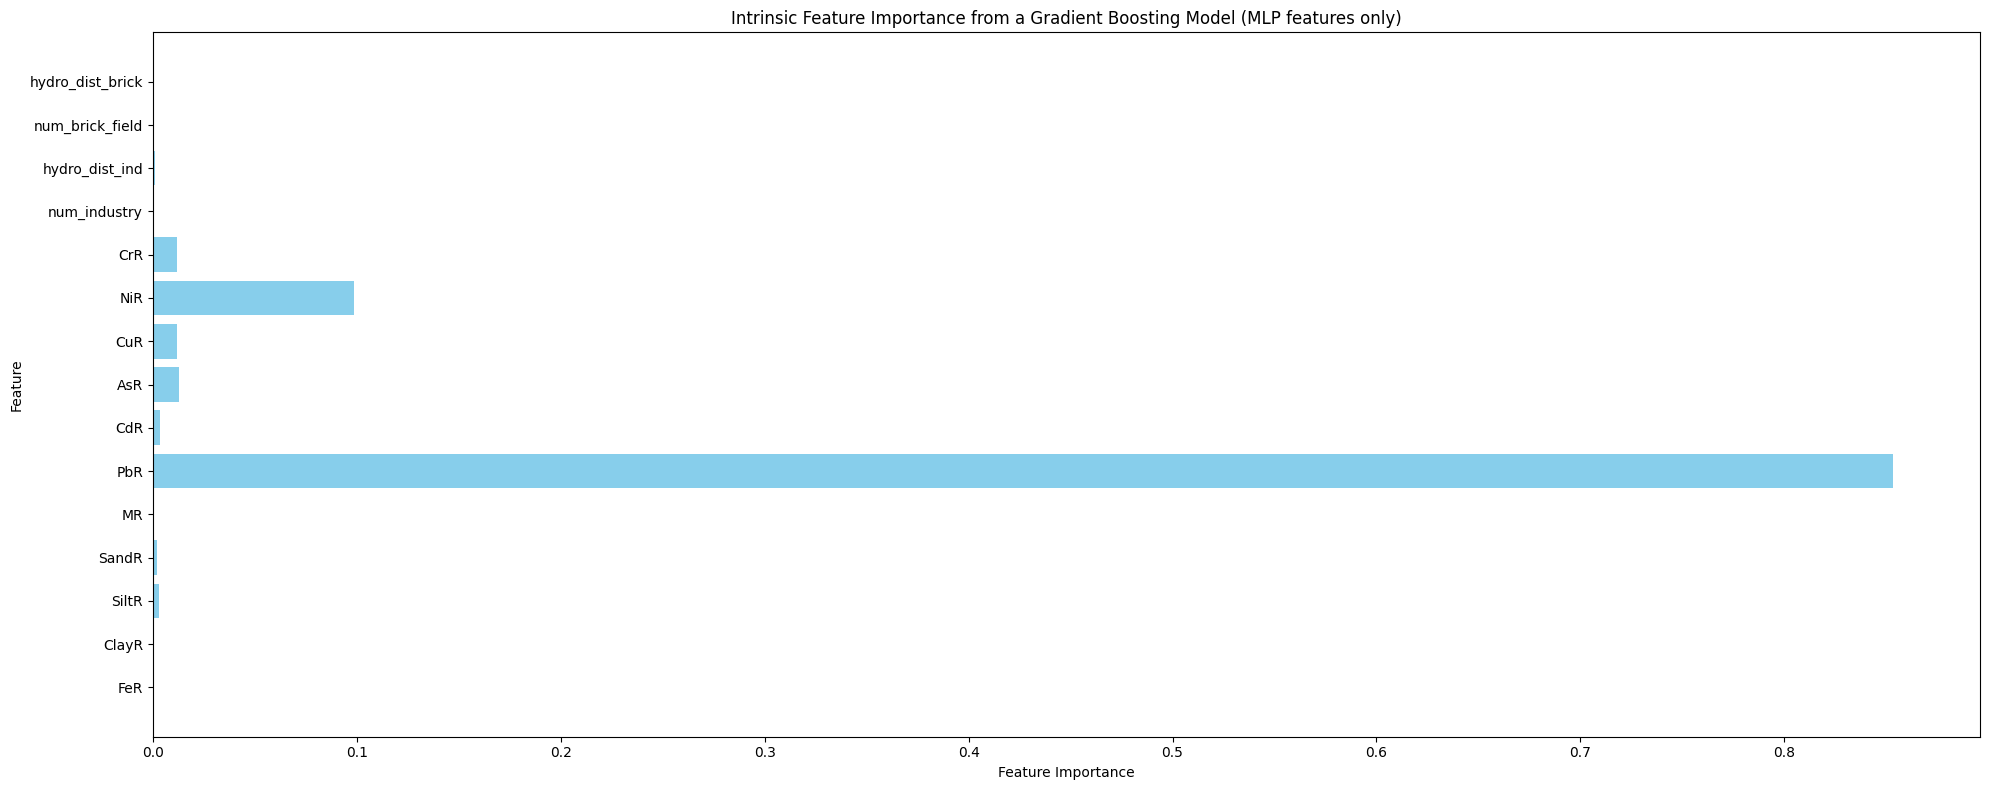

In [22]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from lime.lime_tabular import LimeTabularExplainer

'''
# ==================== 1. Load Data (from previous analysis) ==================== #
# This section remains the same to ensure data is prepared for the new methods.
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

coords_test = test_orig[['Long','Lat']].values
coords_train = train_combined[['Long','Lat']].values
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train_df = train_combined[numeric_cols].copy()
mlp_test_df = test_orig[numeric_cols].copy()
scaler.fit(mlp_train_df)
mlp_test = scaler.transform(mlp_test_df)
y_test = test_orig['RI'].values
BUFFER_METERS = 500
batch_size = 4
'''

# Helper function to get CNN patches, used for LIME and PDP
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    patches = []
    for lon, lat in coords:
        channels = []
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

# Get necessary patch dimensions
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    buffer_pixels_y = int(BUFFER_METERS / res_y)
    patch_width = 2 * buffer_pixels_x
    patch_height = 2 * buffer_pixels_y

test_cnn = extract_patch_for_generator(coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height)


# ==================== 2. Intrinsic Feature Importance (Tree-based Model) ==================== #
# Note: Intrinsic importance is specific to tree-based models and cannot be directly
# applied to your TensorFlow model. This example trains a separate Gradient Boosting
# model on just the MLP features to demonstrate the concept. This is a common
# approach to gain initial insights into the tabular data.
print("\n--- Running Intrinsic Feature Importance Analysis ---")
print("Training a Gradient Boosting Regressor on the MLP features...")

# Create and train a tree-based model on the MLP features
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(mlp_train_df, train_combined['RI'].values)

# Get feature importances
intrinsic_importances = gbr_model.feature_importances_

# Plot the results
plt.figure(figsize=(20, 8))
plt.barh(numeric_cols, intrinsic_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Intrinsic Feature Importance from a Gradient Boosting Model (MLP features only)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



--- Running LIME Analysis for a single data point ---
Generating LIME explanation for instance 4...
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step
Intercept 204.07919009400433
Prediction_local [258.4010096]
Right: 321.22733


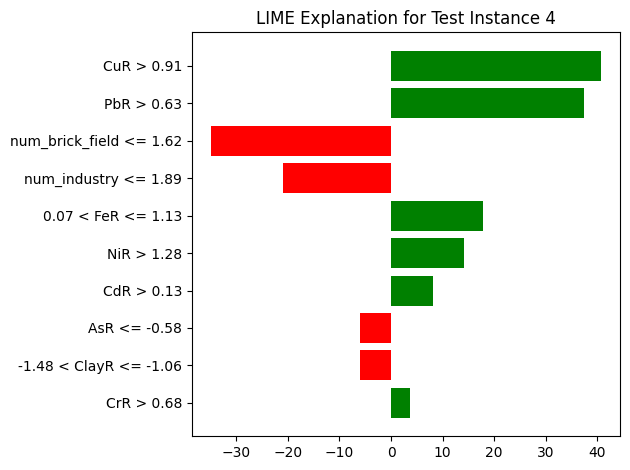

In [23]:
# ==================== 3. LIME (Local Interpretable Model-agnostic Explanations) ==================== #
# LIME explains individual predictions by fitting a local, simple model.
# This is a powerful way to understand *why* a single data point was predicted a certain way.
print("\n--- Running LIME Analysis for a single data point ---")

# First, we need to create a single-input wrapper function for the original model
# so LIME can treat it as a black box. This function takes a concatenated array.
def model_predict_wrapper(X):
    # This wrapper is now specifically for the LIME explainer on MLP/GNN features.
    # It takes the perturbed MLP and GNN data from LIME, but uses a fixed CNN patch
    # from the original instance being explained.
    
    # Separate the MLP and GNN data from the LIME input
    mlp_input = X[:, :mlp_test.shape[1]]
    gnn_input = X[:, mlp_test.shape[1]:]

    # For the CNN input, we'll use a fixed patch from the instance we are explaining.
    # We replicate this patch to match the number of samples LIME creates (X.shape[0]).
    fixed_cnn_input = np.tile(test_cnn[instance_to_explain_idx], (X.shape[0], 1, 1, 1))

    # Pass the inputs to the original model
    return model.predict([fixed_cnn_input, mlp_input, gnn_input]).flatten()

# The LIME analysis will now only use the MLP and GNN features.
combined_test_data = np.hstack([mlp_test, gnn_test])

# Create feature names for the LIME explainer
mlp_feature_names = numeric_cols.tolist()
gnn_feature_names = [f'GNN_{i}' for i in range(gnn_test.shape[1])]
feature_names = mlp_feature_names + gnn_feature_names

# Create the LIME explainer instance
# The kernel_width parameter controls the size of the local area LIME will investigate.
explainer = LimeTabularExplainer(
    training_data=combined_test_data,
    feature_names=feature_names,
    class_names=['RI'], # For regression, use the name of the target
    mode='regression',
    verbose=True
)

# Choose a single instance to explain (e.g., the 5th instance)
instance_to_explain_idx = 4
instance_to_explain = combined_test_data[instance_to_explain_idx]

# Generate the explanation
print(f"Generating LIME explanation for instance {instance_to_explain_idx}...")
explanation = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=model_predict_wrapper,
    num_features=10 # Explain the top 10 most important features for this instance
)

# Plot the LIME explanation
explanation.as_pyplot_figure()
plt.title(f'LIME Explanation for Test Instance {instance_to_explain_idx}')
plt.tight_layout()
plt.show()



--- Running Partial Dependence Plot (PDP) Analysis ---
Available numeric columns for PDP: ['hydro_dist_brick', 'num_brick_field', 'hydro_dist_ind', 'num_industry', 'CrR', 'NiR', 'CuR', 'AsR', 'CdR', 'PbR', 'MR', 'SandR', 'SiltR', 'ClayR', 'FeR']


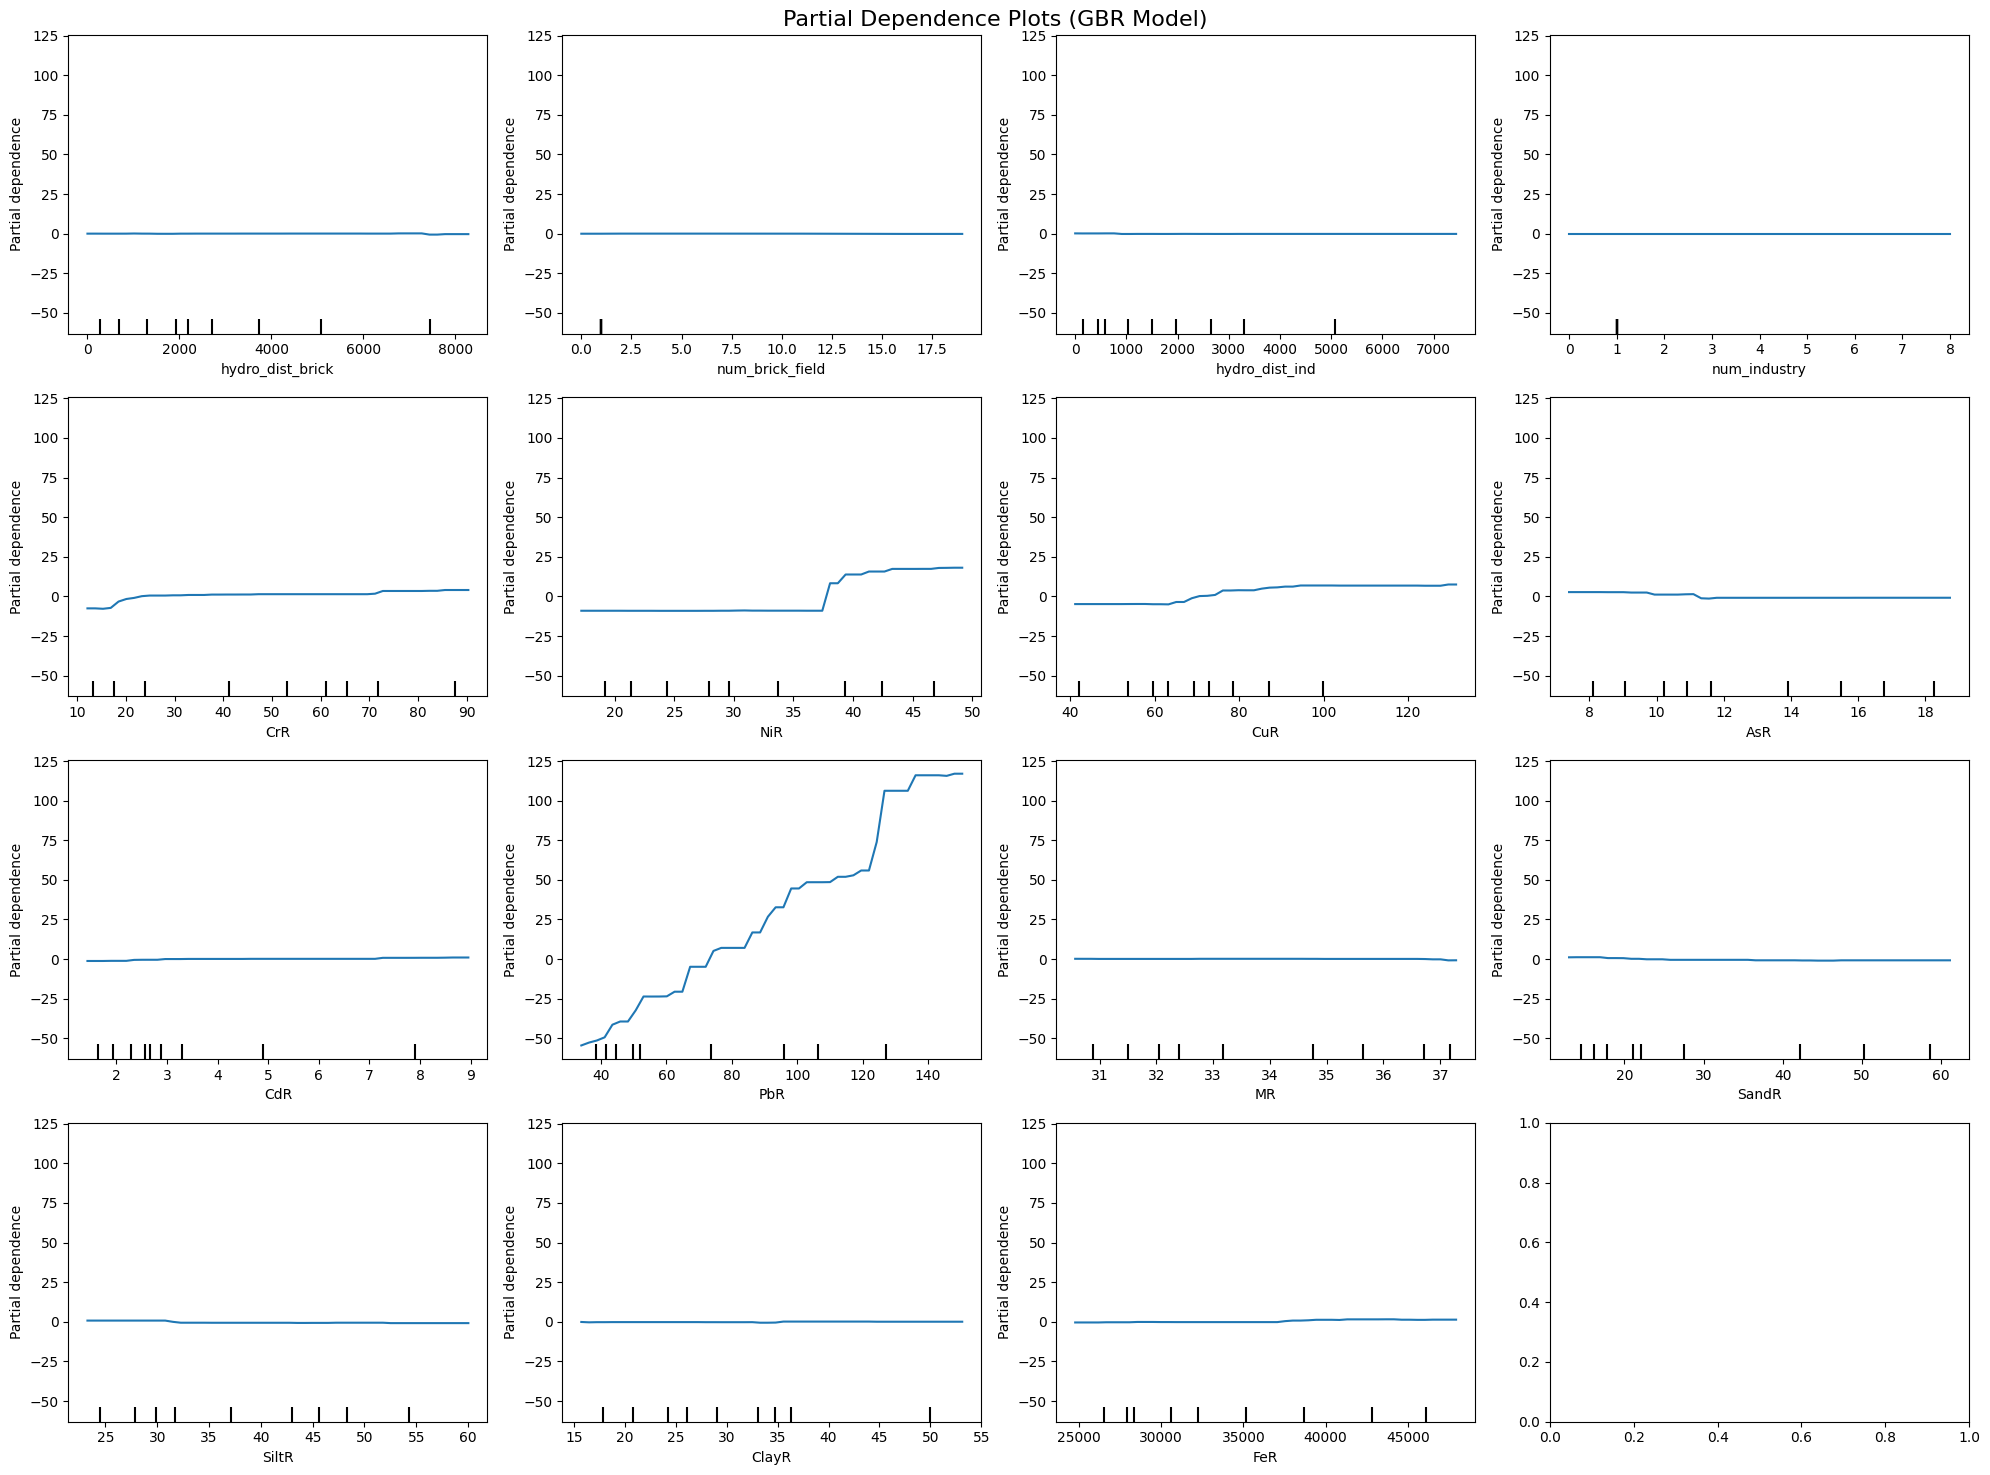

In [24]:
# ==================== 4. Partial Dependence Plots (PDPs) ==================== #
# PDPs show the marginal effect of a feature on the predicted outcome.
# This is a global view of a feature's impact on the model's predictions.
print("\n--- Running Partial Dependence Plot (PDP) Analysis ---")
print("Available numeric columns for PDP:", numeric_cols.tolist())

# PDPs for all features using the GBR model
pdp_features_to_plot_all = numeric_cols.tolist()
pdp_feature_indices_all = list(range(len(numeric_cols)))

# Calculate grid dimensions to ensure the number of subplots matches the number of features
num_features = len(pdp_features_to_plot_all)
n_cols = 4
n_rows = (num_features + n_cols - 1) // n_cols

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))
# Flatten the axes array and slice to the correct size
axes_to_use = ax.flatten()[:num_features]
PartialDependenceDisplay.from_estimator(
    gbr_model,
    X=mlp_train_df,
    features=pdp_feature_indices_all,
    feature_names=numeric_cols.tolist(),
    ax=axes_to_use,
    grid_resolution=50
)
fig.suptitle('Partial Dependence Plots (GBR Model)', fontsize=16)
plt.tight_layout()
plt.show()



--- Manually generating PDP for the full TensorFlow model ---


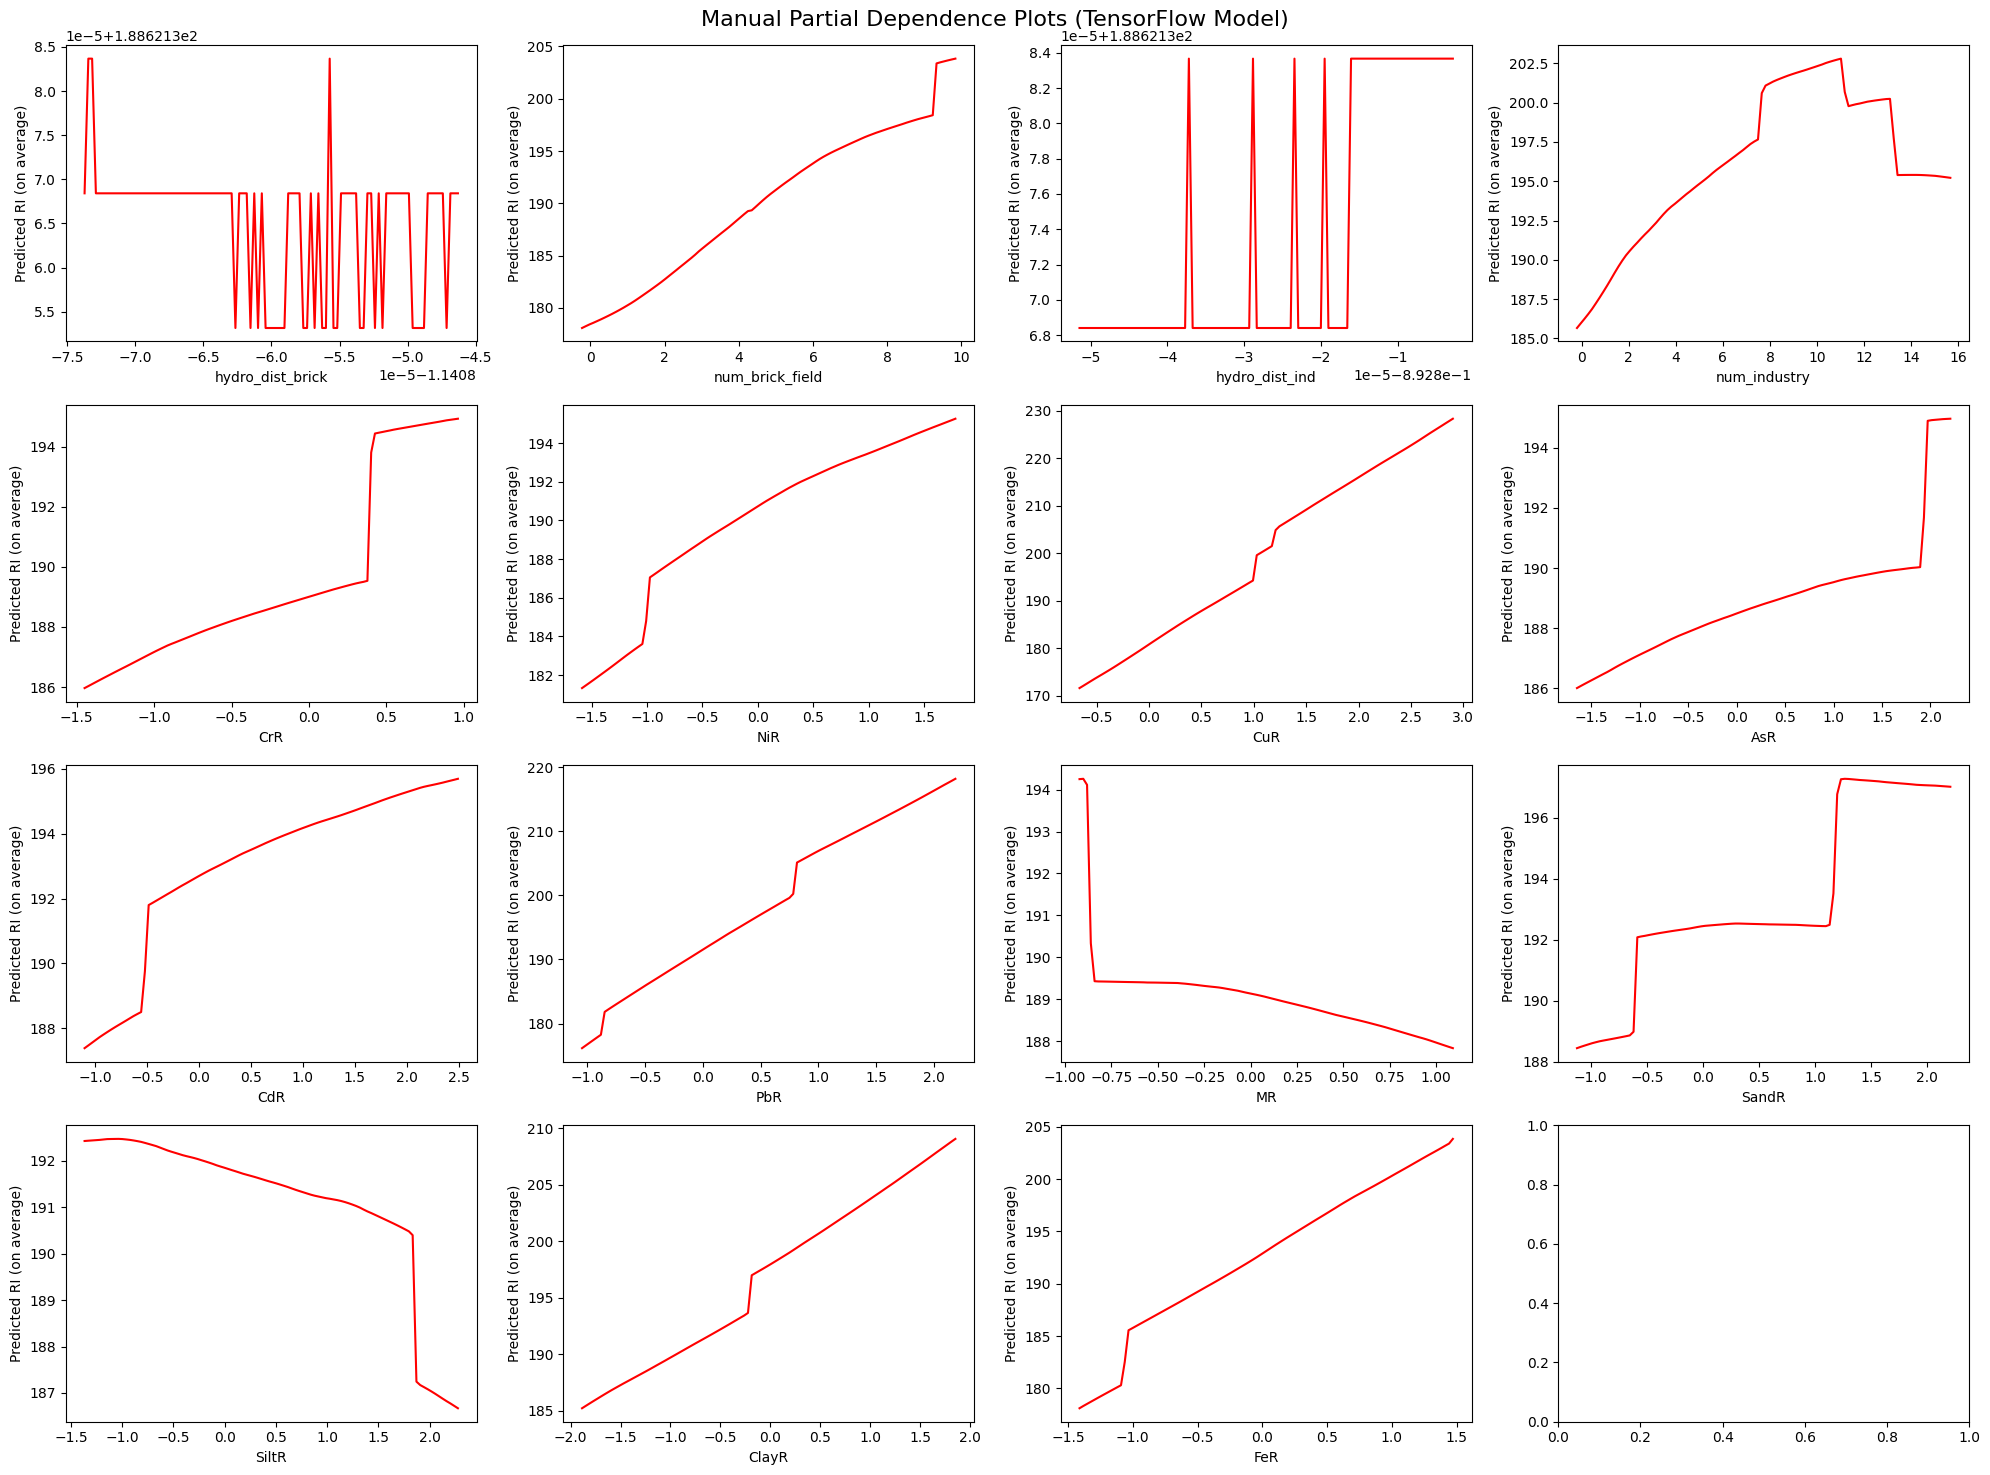


--- Analysis Complete ---


In [25]:
print("\n--- Manually generating PDP for the full TensorFlow model ---")

def manual_pdp(model, feature_name, X_test_cnn, X_test_mlp, X_test_gnn, feature_idx, feature_values=None):
    """Generates a manual PDP for a single feature in a multi-input model."""
    if feature_values is None:
        # Create a range of values for the feature
        feature_values = np.linspace(X_test_mlp[:, feature_idx].min(), X_test_mlp[:, feature_idx].max(), 100)
    
    # Create a copy of the MLP input data
    X_test_mlp_pdp = X_test_mlp.copy()
    
    predictions = []
    for val in feature_values:
        # For each value, set the feature to that value across all instances
        X_test_mlp_pdp[:, feature_idx] = val
        
        # Predict with the model and take the mean
        pred = model.predict([X_test_cnn, X_test_mlp_pdp, X_test_gnn], verbose=0).mean()
        predictions.append(pred)
        
    return feature_values, np.array(predictions)

# Plot the PDPs for the TensorFlow model for all features
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, feature_name in enumerate(pdp_features_to_plot_all):
    feature_idx = numeric_cols.get_loc(feature_name)
    feature_values, pdp_predictions = manual_pdp(model, feature_name, test_cnn, mlp_test, gnn_test, feature_idx)
    axes[i].plot(feature_values, pdp_predictions, color='red')
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('Predicted RI (on average)')
    axes[i].set_title(f'')

fig.suptitle('Manual Partial Dependence Plots (TensorFlow Model)', fontsize=16)
plt.tight_layout()
plt.show()

print("\n--- Analysis Complete ---")


In [29]:
# ==================== 1. Intrinsic Feature Importance Results ==================== #

print("--- Numeric Results: Intrinsic Feature Importance (from GBR) ---")
intrinsic_importances = gbr_model.feature_importances_
importance_dict = dict(zip(numeric_cols, intrinsic_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)
print(sorted_importance)
print("\n")


# ==================== 2. LIME Results ==================== #

print("--- Numeric Results: LIME Explanation (for a single instance) ---")
sorted_lime = sorted(explanation.as_list(), key=lambda x: abs(x[1]), reverse=True)
print(sorted_lime)
print("\n")


# ==================== 3. Partial Dependence Plot (PDP) Results ==================== #

print("--- Numeric Results: Manual PDP Data (for Top 5 Features) ---")
top_5_features = [item[0] for item in sorted_importance[:5]]

for feature_name in top_5_features:
    feature_idx = numeric_cols.tolist().index(feature_name)

    feature_values, pdp_predictions = manual_pdp(model, feature_name, test_cnn, mlp_test, gnn_test, feature_idx)

    print(f"--- PDP Data for: '{feature_name}' ---")
    print(f"Feature Values:")
    print(feature_values)
    print("\nCorresponding Average Predicted RI Values:")
    print(pdp_predictions)
    print("\n")


--- Numeric Results: Intrinsic Feature Importance (from GBR) ---
[('PbR', 0.853253205390119), ('NiR', 0.09881322808711815), ('AsR', 0.012801277462415188), ('CrR', 0.012074729332910593), ('CuR', 0.01167791295612921), ('CdR', 0.003467315801338547), ('SiltR', 0.003131958064428256), ('SandR', 0.0020126438510968936), ('hydro_dist_ind', 0.0011694059771822746), ('ClayR', 0.0005486100053203283), ('FeR', 0.0004861574720681423), ('MR', 0.0004132332485617142), ('hydro_dist_brick', 0.00014412827470258125), ('num_brick_field', 6.194076609055788e-06), ('num_industry', 0.0)]


--- Numeric Results: LIME Explanation (for a single instance) ---
[('CuR > 0.91', 40.67855942082697), ('PbR > 0.63', 37.53052732623117), ('num_brick_field <= 1.62', -34.862967632434255), ('num_industry <= 1.89', -20.946583957188505), ('0.07 < FeR <= 1.13', 17.824513617082882), ('NiR > 1.28', 14.181492967802848), ('CdR > 0.13', 8.209413672956847), ('AsR <= -0.58', -6.0950522090983155), ('-1.48 < ClayR <= -1.06', -5.9797900400644

In [3]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LayerNormalization, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.utils import Sequence

# A note on the Python environment:
# This script assumes you have the following libraries installed:
# pandas, numpy, glob, os, rasterio, scipy, scikit-learn, tensorflow, matplotlib
# If not, you can install them using pip:
# pip install pandas numpy rasterio scipy scikit-learn tensorflow matplotlib

BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.buffer_meters = buffer_meters
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )
        
        return (batch_cnn, batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define Transformer-based Fusion Model ==================== #
def build_transformer_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # Inputs for all branches
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- CNN Branch ---
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_embedding = Flatten(name="cnn_embedding_flatten")(cnn_branch)
    
    # --- MLP Branch ---
    mlp_embedding = Dense(128, activation="relu")(mlp_input)
    mlp_embedding = Dense(64, activation="relu", name="mlp_embedding")(mlp_embedding)

    # --- GNN Branch ---
    gnn_embedding = Dense(128, activation="relu")(gnn_input)
    gnn_embedding = Dense(64, activation="relu", name="gnn_embedding")(gnn_embedding)

    # --- Transformer Fusion ---
    # To feed into the transformer, we need to make all embeddings have the same dimension.
    # Let's use a dense layer to project them to a common size.
    projection_dim = 64
    cnn_proj = Dense(projection_dim)(cnn_embedding)
    mlp_proj = Dense(projection_dim)(mlp_embedding)
    gnn_proj = Dense(projection_dim)(gnn_embedding)

    # Stack the embeddings to create a sequence for the transformer
    # Shape becomes (None, 3, projection_dim)
    # Corrected code to use Keras-compatible operations
    cnn_expanded = Reshape((1, projection_dim))(cnn_proj)
    mlp_expanded = Reshape((1, projection_dim))(mlp_proj)
    gnn_expanded = Reshape((1, projection_dim))(gnn_proj)
    embeddings = Concatenate(axis=1)([cnn_expanded, mlp_expanded, gnn_expanded])

    # Transformer Encoder block
    transformer_output = MultiHeadAttention(
        num_heads=4,
        key_dim=projection_dim
    )(embeddings, embeddings)
    transformer_output = Dropout(0.2)(transformer_output)
    transformer_output = LayerNormalization(epsilon=1e-6)(embeddings + transformer_output)
    
    # The output from the transformer is a sequence of 3 vectors.
    # We flatten this for the final prediction layer.
    transformer_output_flattened = Flatten()(transformer_output)
    
    # Final dense layers for prediction
    f = Dense(128, activation="relu")(transformer_output_flattened)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

batch_size = 4
gnn_input_dim = len(coords_train)

with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

mlp_input_dim = mlp_train.shape[1]

model = build_transformer_fusion_model(cnn_patch_shape, gnn_input_dim, mlp_input_dim)
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    coords=coords_train, mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=True
)


((100, 100, 26), 110, 15)

In [5]:
cnn_patch_shape


(100, 100, 26)

In [ ]:
del model, history, train_generator
gc.collect()
